In [92]:
# df.to_pickle('dataset_lcforest_LOF10_bin30_th3_1km_noprior_ta.pkl')

In [2]:
from scripts.parallel_blocks import *
import pandas as pd

df = pd.read_pickle('dataset_lcforest_mahal22_bin15_th3_fancy1km_noprior_ta.pkl')

df.pg.mean()

6.0306700875070405

### This can be used to adjust dataframes with a new outlier method or regression method.

In [12]:
from scripts.parallel_blocks import *
import pandas as pd

df_ = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')

# Create a column to fill later
df_['outlier'] = np.nan

# Grouping keys
group_keys = ['camera','date','lat','lon']
i=0
# Iterate over each group
for keys, test_plot in df_.groupby(group_keys):
    i+=1
    test_plot = test_plot.copy()

    try:
        coefs, _, test = df_odr(test_plot, outlier_removal=0.22, w=[1, 0.25])

        # Ensure index alignment for merging
        test_plot['outlier'] = test['Outlier'].values

        # Set the values back in the original df using index
        df_.loc[test_plot.index, 'outlier'] = test_plot['outlier']

        indices_to_insert = [i for i in range(1,7) if i not in test['beam'].unique()]

        for index in indices_to_insert:
            coefs = np.insert(coefs, index, None)

        if np.all(np.isnan([coefs[1],coefs[3],coefs[5]])):
            y_strong = np.nan
        else:
            y_strong = np.nanmean([coefs[1],coefs[3],coefs[5]])
            y_strong_max = np.nanmax([coefs[1],coefs[3],coefs[5]])
            
        if np.all(np.isnan([coefs[2],coefs[4],coefs[6]])):
            y_weak = np.nan
        else:
            y_weak = np.nanmean([coefs[2],coefs[4],coefs[6]])
            y_weak_max = np.nanmax([coefs[2],coefs[4],coefs[6]])
            
        if np.any(np.isnan([y_strong, y_weak])):
            pv_ratio_mean = np.nan
            pv_ratio_max = np.nan
        else:
            pv_ratio_mean = y_strong/y_weak
            pv_ratio_max = y_strong_max/y_weak_max
        
        y_intercept_dict = {1: coefs[1], 2: coefs[2], 3: coefs[3], 4: coefs[4], 5: coefs[5], 6: coefs[6]}
        x_intercept_dict = {1: -coefs[1]/coefs[0], 2: -coefs[2]/coefs[0], 3: -coefs[3]/coefs[0], 4: -coefs[4]/coefs[0],
                           5: -coefs[5]/coefs[0], 6: -coefs[6]/coefs[0]}

        df_.loc[test_plot.index,'pvpg'] = -coefs[0]
        df_.loc[test_plot.index,'pv'] = test_plot['beam'].map(y_intercept_dict)
        df_.loc[test_plot.index,'pg'] = test_plot['beam'].map(x_intercept_dict)
        df_.loc[test_plot.index,'pv_ratio_max'] = pv_ratio_max
        df_.loc[test_plot.index,'pv_ratio_mean'] = pv_ratio_mean

    except Exception as e:
        print(f"Skipping group {keys} due to error: {e}")
        continue

    # print(params)
    # print(test_plot)
    # print(test)

# All 18 Sites!

In [19]:
data[(data['FSC'] > 0) & (data['FSC'] < 1)]

,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,fsc_category
200,delta_junction,30/04/2022,63.867586,-145.787644,0.344281,1.625753,4.722165,3.076564,0.470588,0.933333,...,0.95,0.0,0.000000,19.0,0.0,1.821124,1.821124,1.0,Ground Snow,Between 0 and 1
203,delta_junction,30/04/2022,63.894614,-145.794326,0.541602,2.190381,4.044266,2.151261,0.909627,0.571429,...,0.95,0.0,0.532258,19.0,0.0,1.957856,1.957856,1.0,Ground Snow,Between 0 and 1
267,glees,28/05/2023,41.359895,-106.214109,0.627306,2.504540,3.992535,1.829762,1.414286,0.555556,...,0.96,0.0,0.000000,19.0,0.0,2.066404,2.066404,1.0,Ground Snow,Between 0 and 1
533,kenttarova,25/05/2020,67.955751,24.208633,0.246409,1.627780,6.606019,3.190476,0.785714,0.500000,...,0.99,0.0,0.000000,9.0,0.0,1.546644,1.546644,1.0,Ground Snow,Between 0 and 1
534,kenttarova,25/05/2020,67.964760,24.211748,0.234296,1.810812,7.728741,3.166667,0.828571,0.547917,...,0.99,0.0,0.000000,9.0,0.0,1.632391,1.632391,1.0,Ground Snow,Between 0 and 1
535,kenttarova,25/05/2020,67.973769,24.214672,0.381058,1.871356,4.910947,3.095238,0.750000,0.933333,...,0.99,0.0,0.000000,9.0,0.0,2.117518,2.117518,1.0,Ground Snow,Between 0 and 1
536,kenttarova,25/05/2020,67.982778,24.217766,0.286985,1.719973,5.993251,2.388095,1.025000,0.818182,...,0.99,0.0,0.000000,9.0,0.0,1.898168,1.898168,1.0,Ground Snow,Between 0 and 1
537,kenttarova,25/05/2020,67.991788,24.220725,0.497106,2.498636,5.026362,3.166667,0.651515,0.732143,...,0.99,0.0,0.000000,9.0,0.0,2.035337,2.035337,1.0,Ground Snow,Between 0 and 1
538,kenttarova,25/05/2020,68.000797,24.223756,0.108291,0.905596,8.362647,3.952381,0.476190,1.083333,...,0.99,0.0,0.000000,9.0,0.0,2.125269,2.125269,1.0,Ground Snow,Between 0 and 1
540,kenttarova,25/05/2020,68.018815,24.151378,0.198234,1.229721,6.203377,2.823529,0.619195,0.541958,...,0.99,0.0,0.000000,9.0,0.0,1.256914,1.256914,1.0,Ground Snow,Between 0 and 1


1771
598


/tmp/ipykernel_4114938/3758040898.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


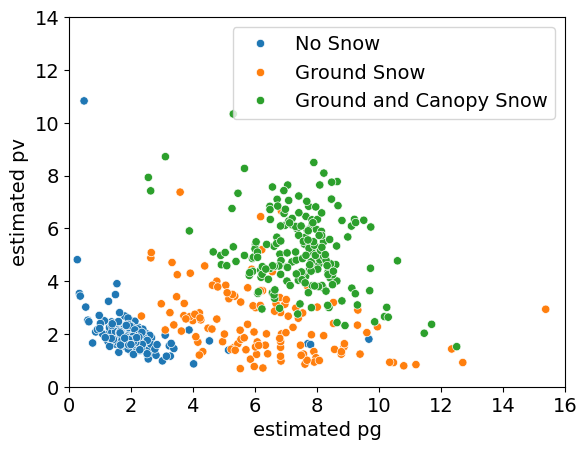

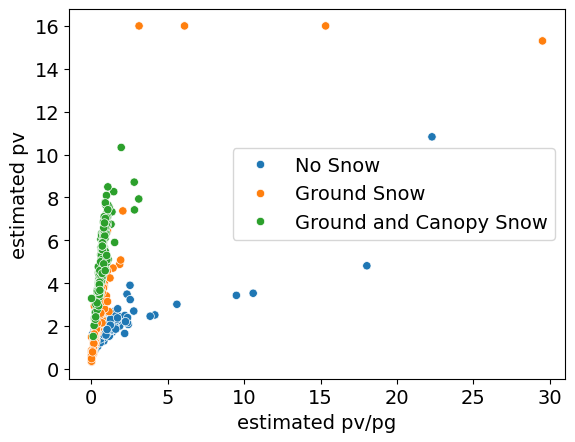

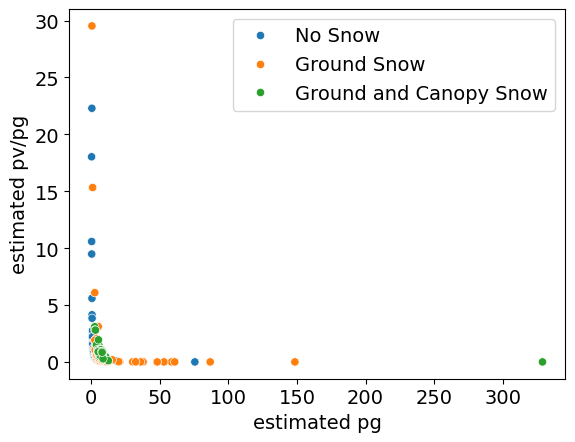

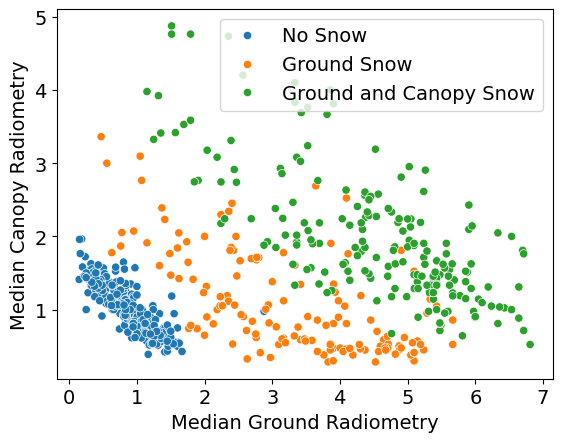

In [11]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta_reclassified_v2.pkl')
# df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy750m_noprior_ta.pkl')

# df = df_.copy()
# print(df)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

# First create masked columns
df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)
df['forest_type'] = np.where(df['segment_landcover']<119, 'closed', 'open')

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
    'forest_type': lambda x: pd.Series.mode(x).iloc[0],
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
print(len(df_grouped[((df_grouped['FSC'] < 0.001)|(df_grouped['FSC'] > 0.999))]))
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
# camera_counts = df_grouped['camera'].value_counts()
data = df_grouped[((df_grouped['FSC'] <= 0.005)|(df_grouped['FSC'] >= 0.995))
    &((df_grouped['TreeSnow'] == 0)|(df_grouped['TreeSnow'] == 1))
    &(df_grouped['Eg_strong'] <= 16)&(df_grouped['Ev_strong'] <= 16)#&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] <= 0.2))&(df_grouped['data_quantity'] >= 7)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))
camera_counts = data['camera'].value_counts()

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})
print(len(data))

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([4.2,0],[0,9],'r--') #LOF10_bin20_DW 570 points
# plt.plot([5,0],[0,7.5],'r--') #LOF10_bin30_DW 596 points
                                #LOF10_bin20 578 points
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg_strong', y='Ev_strong', hue='Conditions')#, size='data_quantity')
plt.xlabel('Median Ground Radiometry')
plt.ylabel('Median Canopy Radiometry')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin20 570 points
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin30 596 points
plt.legend(loc='best')
plt.show()

# data[(data['forest_type']=='closed')&(data['camera']=='varrio')] #glees, ojk, oregon, torgnon, varrio

In [6]:
# df.info(), df_grouped.info(), data.info()

#### Logistic Regression

/tmp/ipykernel_4114938/3107973972.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowRounded'] = data['JointSnow'].round().astype(int)
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warn

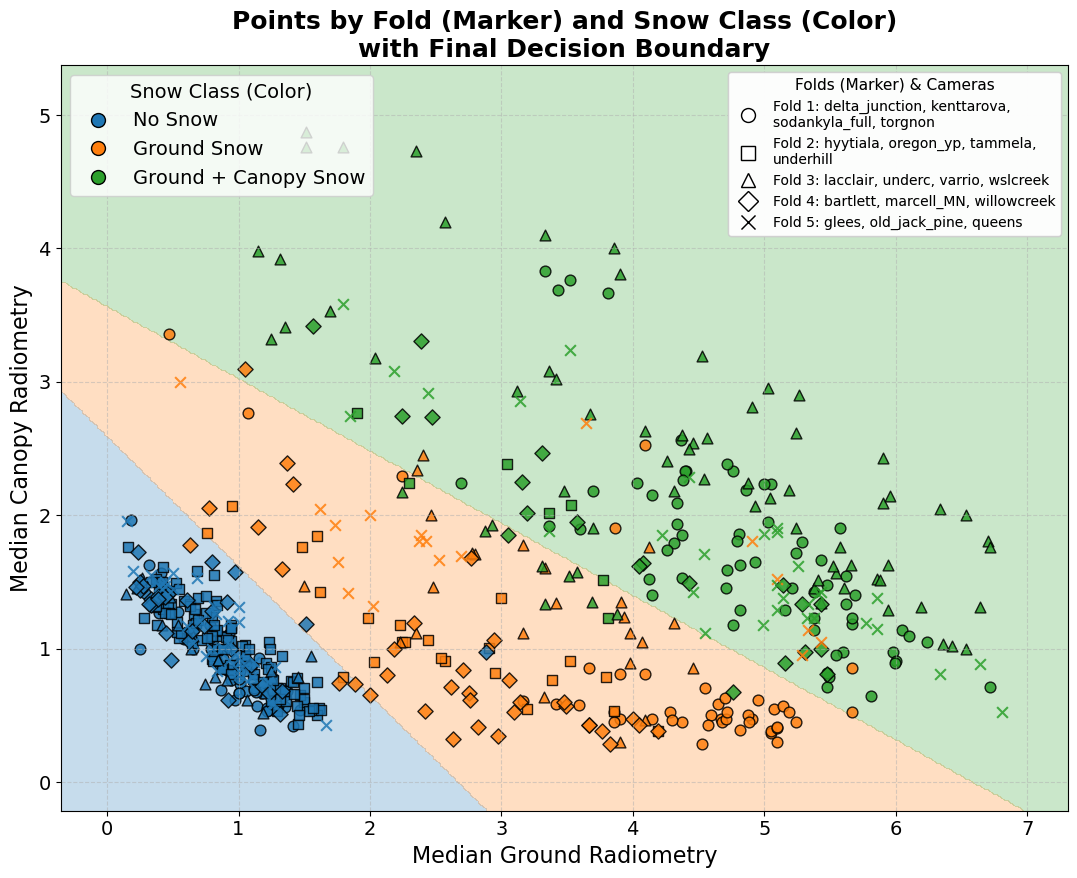

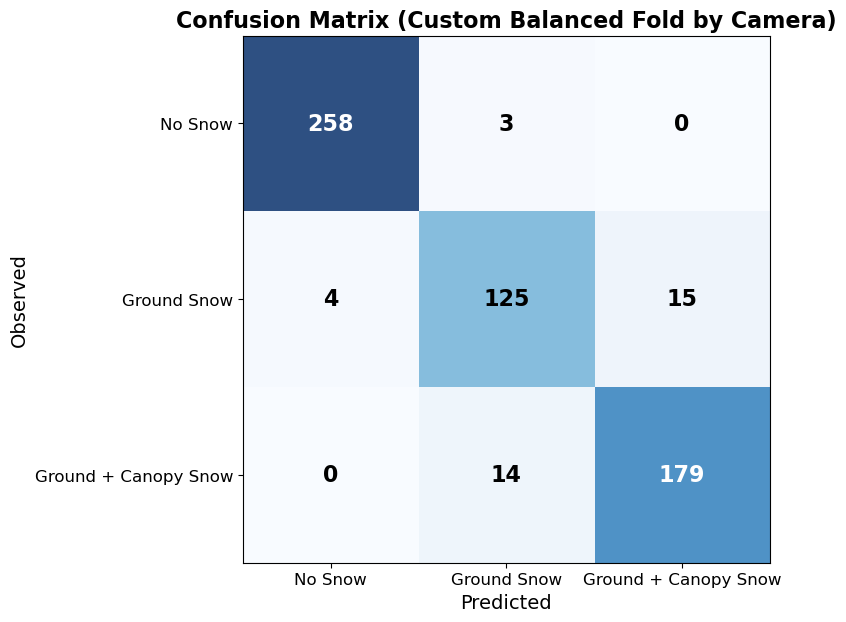

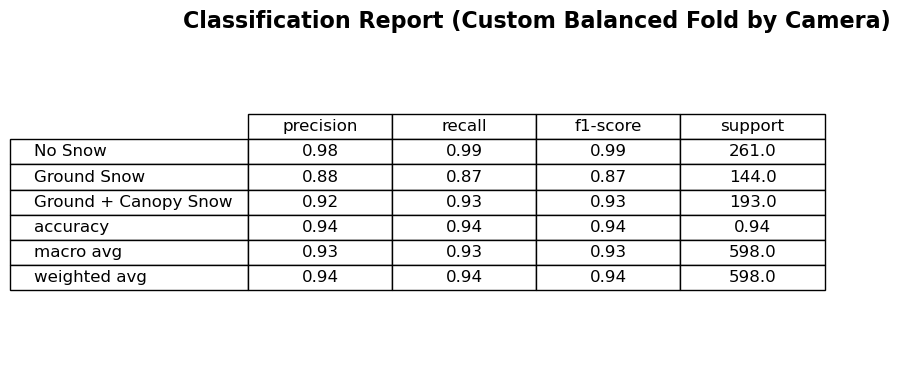

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from textwrap import fill

# --- Prepare Data ---
data['JointSnowRounded'] = data['JointSnow'].round().astype(int)
features = ['Eg_strong', 'Ev_strong']
target = 'JointSnowRounded'

X = data[features].values
y = data[target].values

# --- Create Custom Balanced GroupKFold on "camera" ---
n_splits = 5

# Ensure camera_counts exists (uncommented)
camera_counts = data['camera'].value_counts()
sorted_cameras = camera_counts.index.tolist()

# Assign each camera to a fold in round-robin fashion
camera_to_fold = {}
for i, cam in enumerate(sorted_cameras):
    camera_to_fold[cam] = i % n_splits

# Assign fold index to each row
group_indices = data['camera'].map(camera_to_fold).values

# Prepare containers
labels_str = ['No Snow', 'Ground Snow', 'Ground + Canopy Snow']
class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
group_markers = ['o', 's', '^', 'D', 'x']  # Marker per fold

all_y_true = []
all_y_pred = []
final_model = None
final_test_idx = None

# Keep a mapping from fold -> list of cameras for the on-plot panel
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)

# --- Cross-validation using custom folds ---
for fold_idx in range(n_splits):
    test_idx = np.where(group_indices == fold_idx)[0]
    train_idx = np.where(group_indices != fold_idx)[0]

    model = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                               max_iter=1000, random_state=42, penalty=None)
    model.fit(X[train_idx], y[train_idx])
    y_pred = model.predict(X[test_idx])

    all_y_true.extend(y[test_idx])
    all_y_pred.extend(y_pred)

    if fold_idx == n_splits - 1:
        final_model = model
        final_test_idx = test_idx

# Train on entire set for a clean decision boundary
train_idx = np.where(group_indices != n_splits)[0]
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                           max_iter=1000, random_state=42, penalty=None)
model.fit(X[train_idx], y[train_idx])
final_model = model

# --- Mesh for decision boundary ---
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = final_model.predict(grid).reshape(xx.shape)

from textwrap import fill

# --- Plot ---
fig, ax = plt.subplots(figsize=(11, 9))
plt.rcParams.update({'font.size': 14})

# Decision boundary background
ax.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5, 0.5, 1.5, 2.5], colors=class_colors)

# Overlay all data points colored by class, styled by fold (no per-scatter labels)
for fold in range(n_splits):
    for cls in [0, 1, 2]:
        mask = (group_indices == fold) & (y == cls)
        ax.scatter(X[mask, 0], X[mask, 1],
                   color=class_colors[cls], marker=group_markers[fold],
                   edgecolor='k', s=60, alpha=0.85)

# --- Class legend (color) ---
class_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               markerfacecolor=class_colors[i], markeredgecolor='k', markersize=10)
    for i in range(3)
]
class_legend = ax.legend(class_handles, labels_str,
                         title='Snow Class (Color)', loc='upper left', frameon=True)
ax.add_artist(class_legend)

# --- Combined Fold (marker) + camera list block in TOP RIGHT ---
# Build one legend entry per fold with marker handle and wrapped camera list
fold_handles = []
fold_labels = []
wrap_width = 44  # tweak for your figure size

for f in range(n_splits):
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white', markeredgecolor='k', markersize=10)
    cams = sorted(fold_to_cameras[f])
    cams_text = ", ".join(cams) if cams else "(no cameras)"
    label = f"Fold {f+1}: {cams_text}"
    # wrap to keep the block compact
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))

fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds (Marker) & Cameras',
                        loc='upper right', frameon=True, fontsize=10, title_fontsize=11)
ax.add_artist(fold_legend)

# --- Labels (simplified axis titles) ---
ax.set_xlabel('Median Ground Radiometry', fontsize=16)
ax.set_ylabel('Median Canopy Radiometry', fontsize=16)
ax.set_title('Points by Fold (Marker) and Snow Class (Color)\nwith Final Decision Boundary',
             fontsize=18, weight='bold')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# --- Confusion Matrix (All folds) ---
cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Blues', alpha=0.85)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=16, fontweight='bold',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(labels_str, fontsize=12)
ax.set_yticklabels(labels_str, fontsize=12)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Observed', fontsize=14)
plt.title('Confusion Matrix (Custom Balanced Fold by Camera)', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# --- Classification Report (All folds) ---
report_dict = classification_report(all_y_true, all_y_pred,
                                    target_names=labels_str, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

fig, ax = plt.subplots(figsize=(9, 4))
ax.axis('off')
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)
plt.title('Classification Report (Custom Balanced Fold by Camera)', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


# Plotting ATL08 from the Dataframe

In [55]:
# from scripts.parallel_blocks import *
    
# # misclassified.columns
# for idx, row in misclassified.iterrows():
#     if row['FSC'] <= 0.05:
#         plt.figure()
#         plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
        
#         test_plot = df[(df['camera'] == row['camera']) &
#                        (df['date'] == row['date']) &
#                        (df['lon'] == row['lon']) &
#                        (df['lat'] == row['lat'])].copy()

#         params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

#         # print(test)

#         # Get sorted unique beams (hue order used by seaborn)
#         beam_order = sorted(test['beam'].unique())

#         # Create mapping from beam label to tab10 color
#         tab10 = cm.get_cmap('tab10')
#         color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

#         # Plot with fixed hue order and palette
#         sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
#                         hue_order=beam_order, palette=color_map)

#         # Plot ODR lines in matching colors
#         for b, beam in zip(params[1:], beam_order):
#             plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

#         plt.xlim(0, 8)
#         plt.ylim(0, 8)
#         plt.legend()
#         plt.show()

#         # break

# Fractional

/tmp/ipykernel_951959/239723488.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


683


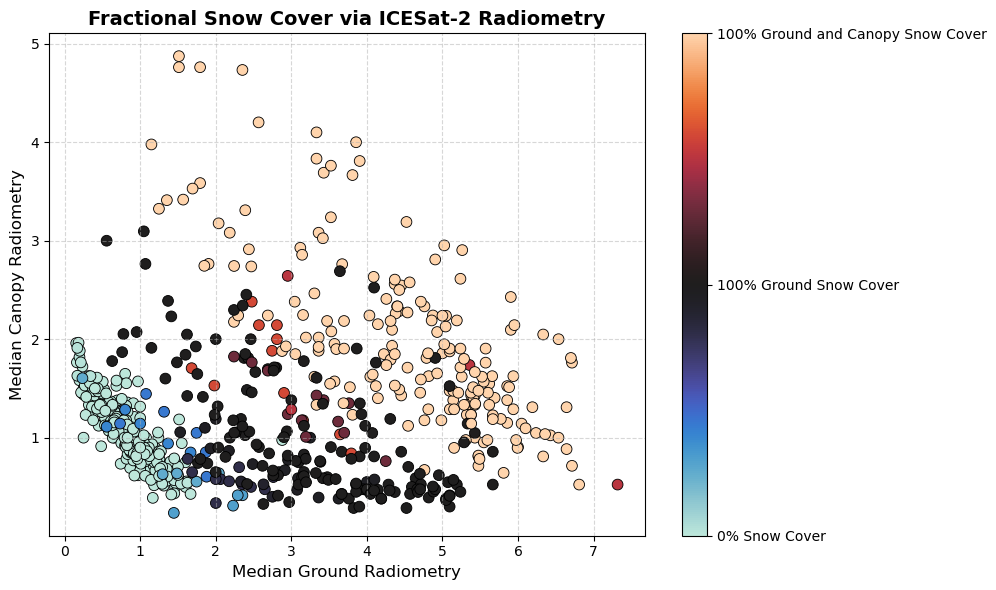

In [1]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta_reclassified_v2.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['Eg_strong'] <= 16)&(df_grouped['Ev_strong'] <= 16)#&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)
    &((df_grouped['layer_flag'] <= 0.2)&(df_grouped['msw_flag'] <= 0.2))&(df_grouped['data_quantity'] >= 7)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)
print(len(frac_data))

plt.figure(figsize=(10, 6))
ax = plt.gca()
scatter = sns.scatterplot(
    data=frac_data.sort_values('FSC'),
    x='Eg_strong', y='Ev_strong',
    hue='JointSnow', palette='icefire', edgecolor='black', s=60, ax=ax, legend=False
)

# Add manual colorbar
norm = plt.Normalize(0, 2)
sm = plt.cm.ScalarMappable(cmap='icefire', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Snow Cover Category', fontsize=12)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['0% Snow Cover', '100% Ground Snow Cover', '100% Ground and Canopy Snow Cover'])

# Set axes and title
plt.xlabel('Median Ground Radiometry', fontsize=12)
plt.ylabel('Median Canopy Radiometry', fontsize=12)
plt.title('Fractional Snow Cover via ICESat-2 Radiometry', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('poster_reclassified_FSC_icefire.svg')
plt.show()


/tmp/ipykernel_3582932/2894421469.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['Partial Snow'] = frac_data['FSC'].apply(lambda x: 'No' if x in [0, 1] else 'Yes')


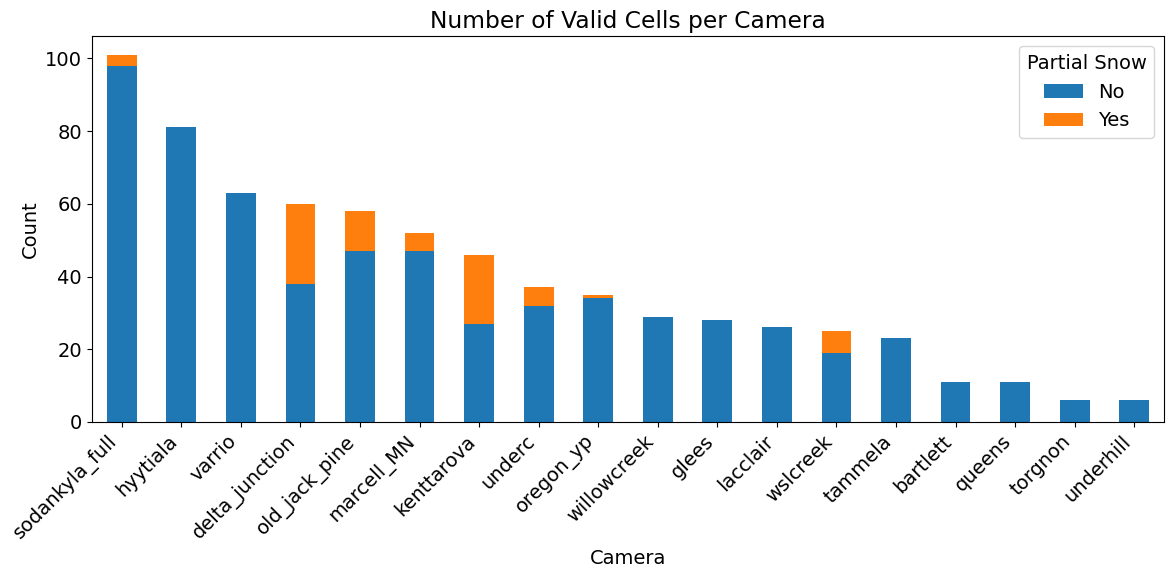

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Categorize FSC values
frac_data['Partial Snow'] = frac_data['FSC'].apply(lambda x: 'No' if x in [0, 1] else 'Yes')

# Count occurrences per camera per FSC category
counts = frac_data.groupby(['camera', 'Partial Snow']).size().unstack(fill_value=0)

# Sort cameras by total count
counts = counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]

# Plot
counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Camera')
plt.ylabel('Count')
plt.title('Number of Valid Cells per Camera')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_4010807/620431265.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  face_cmap = get_cmap(cmap_name)
/tmp/ipykernel_4010807/620431265.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_cmap = get_cmap('tab20')


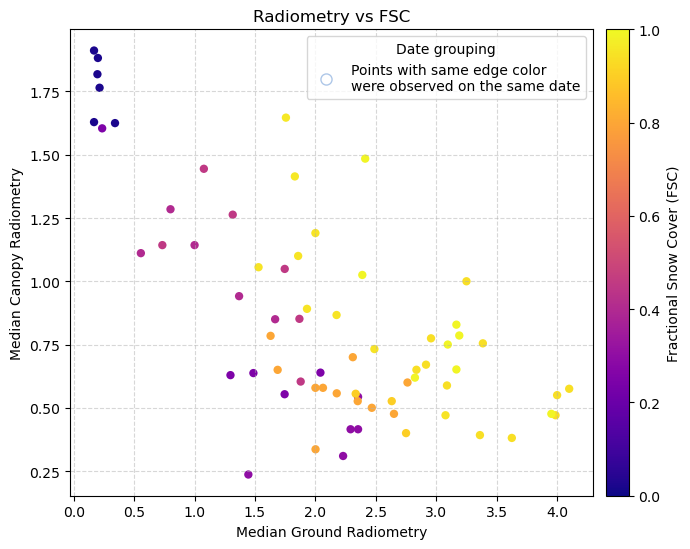

/tmp/ipykernel_4010807/620431265.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  face_cmap = get_cmap(cmap_name)
/tmp/ipykernel_4010807/620431265.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_cmap = get_cmap('tab20')


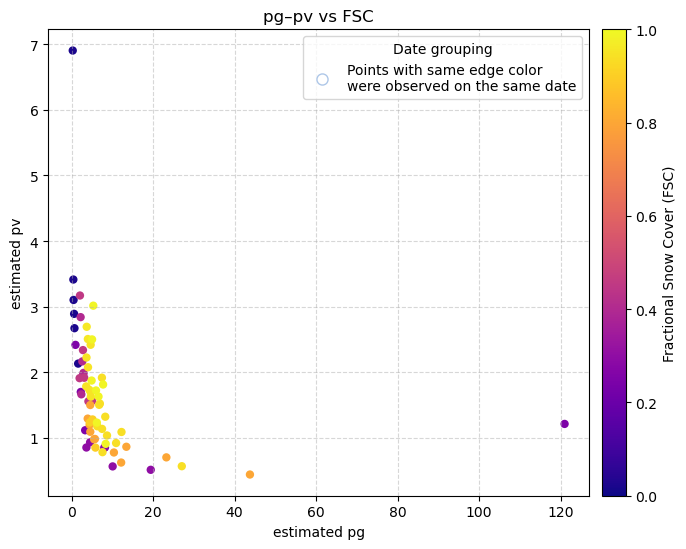

69


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,JointSnowBinary
71,delta_junction,02/05/2021,63.867586,-145.769149,0.105647,0.846117,8.008945,2.352941,0.543344,0.944444,...,0.866235,0.30,0.0,0.000000,16.0,0.0,1.613743,1.613743,0.30,0.30
201,delta_junction,30/04/2022,63.876595,-145.789911,0.514998,2.074235,4.027656,1.930341,0.891003,0.857143,...,103.866039,0.95,0.0,0.049505,19.0,0.0,2.114363,2.114363,0.95,0.95
200,delta_junction,30/04/2022,63.867586,-145.787644,0.344281,1.625753,4.722165,3.076564,0.470588,0.933333,...,104.484682,0.95,0.0,0.000000,19.0,0.0,1.821124,1.821124,0.95,0.95
161,delta_junction,26/04/2024,63.885605,-145.692237,0.010000,1.209591,120.959131,2.041522,0.639006,0.875000,...,0.419218,0.25,0.0,0.000000,32.0,0.0,0.612643,0.612643,0.25,0.25
158,delta_junction,26/04/2024,63.876595,-145.756934,0.752970,1.696849,2.253542,1.486842,0.637218,0.436508,...,0.303764,0.25,0.0,0.000000,32.0,0.0,1.380338,1.380338,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,wslcreek,23/10/2023,39.886895,-105.906864,7.901546,3.412378,0.431862,0.168067,1.628959,0.118056,...,0.346216,0.02,0.0,0.000000,14.0,0.0,1.357800,1.357800,0.02,0.02
1910,wslcreek,23/10/2023,39.886895,-105.869129,3.788957,2.669840,0.704637,0.200000,1.882353,0.125000,...,0.354365,0.02,0.0,0.000000,14.0,0.0,1.421578,1.421578,0.02,0.02
1911,wslcreek,23/10/2023,39.895905,-105.905789,4.672310,2.888945,0.618312,0.213904,1.764706,0.118056,...,0.357741,0.02,0.0,0.000000,14.0,0.0,1.572030,1.572030,0.02,0.02
1912,wslcreek,23/10/2023,39.895905,-105.868679,1.324042,2.129884,1.608623,0.341667,1.625000,0.211111,...,0.298746,0.02,0.0,0.000000,14.0,0.0,1.482770,1.482770,0.02,0.02


In [1]:
from scripts.imports import *
import matplotlib as mpl
from matplotlib.cm import get_cmap

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta_reclassified.pkl')

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak']   = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak']   = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()

df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']

frac_data = df_grouped[
    (df_grouped['FSC'].between(0.0, 1.0, inclusive='neither')) &
    (df_grouped['Eg_strong'] <= 16) & (df_grouped['Ev_strong'] <= 16) &
    ((df_grouped['layer_flag'] <= .2) & (df_grouped['msw_flag'] <= 0.2)) &
    (df_grouped['data_quantity'] >= 7) &
    (df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)
].copy()

frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

# --- Helper: scatter with FSC colorbar + date edge-color legend (top-right) ---
def scatter_fsc_with_date_edges(data, x, y, xlab, ylab, title=None, cmap_name='plasma'):
    fig, ax = plt.subplots(figsize=(7.2, 5.6))

    # Facecolor by FSC (continuous), fixed [0,1] range for consistency
    fsc = data['FSC'].to_numpy(dtype=float)
    face_cmap = get_cmap(cmap_name)
    vmin, vmax = 0.0, 1.0

    # Edgecolor by date (categorical). Colors cycle if > colormap size, which is fine for grouping.
    date_codes, _dates = pd.factorize(data['date'])
    edge_cmap = get_cmap('tab20')
    edge_colors = edge_cmap((date_codes % edge_cmap.N) / edge_cmap.N)

    sc = ax.scatter(
        data[x], data[y],
        c=fsc, cmap=face_cmap, vmin=vmin, vmax=vmax,
        s=36, linewidths=0, edgecolors=edge_colors
    )

    # Colorbar clearly labeled as Fractional Snow Cover
    cbar = fig.colorbar(sc, ax=ax, pad=0.02)
    cbar.set_label('Fractional Snow Cover (FSC)')

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if title:
        ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Compact legend explaining date grouping (top-right)
    sample_handles = [
        mpl.lines.Line2D([0], [0], marker='o', linestyle='',
                         markerfacecolor='white', markeredgecolor=edge_cmap(0.05),
                         markersize=8, label='Points with same edge color\nwere observed on the same date')
    ]
    ax.legend(handles=sample_handles, loc='upper right', frameon=True, title='Date grouping')

    plt.tight_layout()
    plt.show()

# --- Plot 1: Eg_strong vs Ev_strong (color = FSC, edge color = date) ---
scatter_fsc_with_date_edges(
    frac_data.sort_values('FSC'),
    x='Eg_strong', y='Ev_strong',
    xlab='Median Ground Radiometry',
    ylab='Median Canopy Radiometry',
    title='Radiometry vs FSC'
)

# --- Plot 2: pg vs pv (color = FSC, edge color = date) ---
scatter_fsc_with_date_edges(
    frac_data.sort_values('FSC'),
    x='pg', y='pv',
    xlab='estimated pg', ylab='estimated pv',
    title='pg–pv vs FSC'
)

print(len(frac_data))
frac_data.sort_values('camera')


### Model Testing


Camera-to-Fold Assignment:

Fold 1:
  - sodankyla_full: 101 total (98 binary, 3 fractional)
  - underc: 36 total (31 binary, 5 fractional)
  >> Fold 1 Total: 137 points (129 binary, 8 fractional)

Fold 2:
  - old_jack_pine: 58 total (47 binary, 11 fractional)
  - oregon_yp: 33 total (33 binary, 0 fractional)
  - glees: 28 total (28 binary, 0 fractional)
  - bartlett: 11 total (11 binary, 0 fractional)
  - torgnon: 5 total (5 binary, 0 fractional)
  >> Fold 2 Total: 135 points (124 binary, 11 fractional)

Fold 3:
  - delta_junction: 56 total (38 binary, 18 fractional)
  - varrio: 62 total (62 binary, 0 fractional)
  - tammela: 23 total (23 binary, 0 fractional)
  >> Fold 3 Total: 141 points (123 binary, 18 fractional)

Fold 4:
  - marcell_MN: 52 total (47 binary, 5 fractional)
  - wslcreek: 23 total (17 binary, 6 fractional)
  - willowcreek: 29 total (29 binary, 0 fractional)
  - lacclair: 24 total (24 binary, 0 fractional)
  - underhill: 6 total (6 binary, 0 fractional)
  >> Fold 4 To

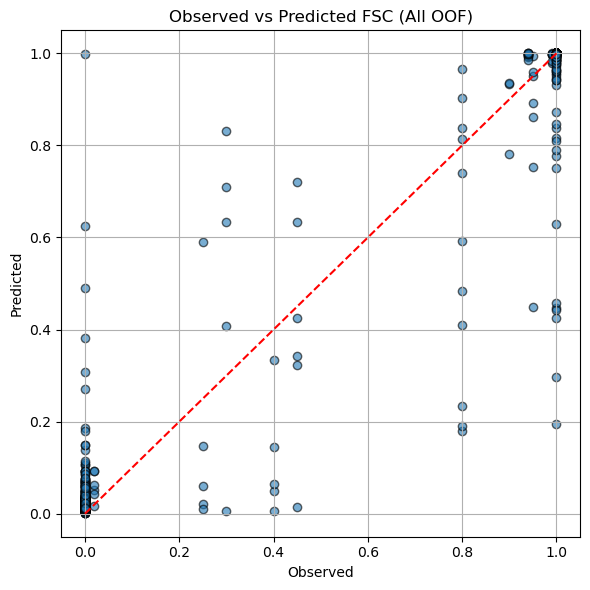

/tmp/ipykernel_951959/691553461.py:305: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],


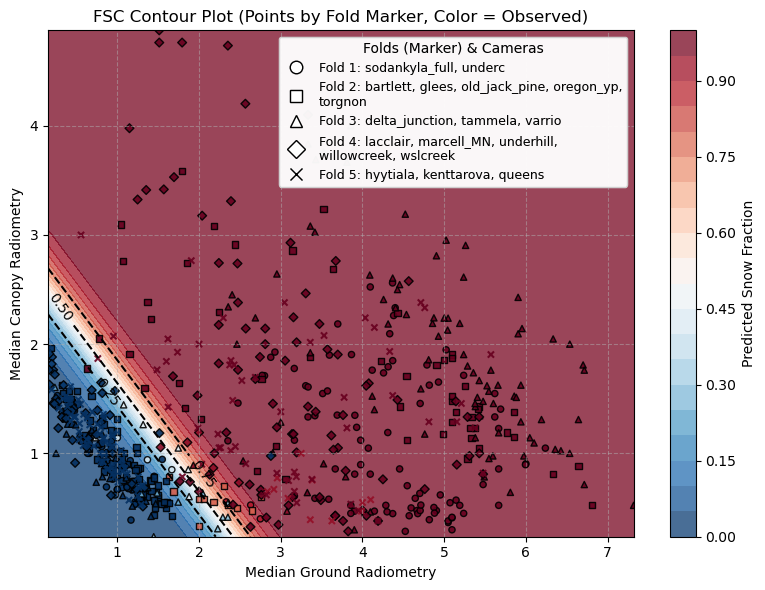

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
from collections import defaultdict

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# def sharpen_probs(p, alpha):
#     p = np.clip(p, 0, 1)
#     return p**alpha / (p**alpha + (1 - p)**alpha)

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date", "camera"]).copy()
combined = df.copy()

X = combined[["Eg_strong", "Ev_strong"]]
y = combined["JointSnowBinary"]

# --- Custom Balanced Group Split by Camera ---
n_splits = 5
camera_groups = combined.groupby("camera")

# Sort cameras by total sample count
sorted_cameras = sorted(camera_groups.groups.keys(), key=lambda cam: len(camera_groups.get_group(cam)), reverse=True)

folds = [[] for _ in range(n_splits)]
fold_sample_counts = [0] * n_splits
fold_frac_counts = [0] * n_splits
camera_to_fold = {}

# Assign cameras with fractional data first
for cam in sorted_cameras:
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    has_fractional = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).any()

    if has_fractional:
        idx = np.argmin(fold_frac_counts)
        folds[idx].extend(cam_data.index.tolist())
        fold_sample_counts[idx] += n
        fold_frac_counts[idx] += ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        camera_to_fold[cam] = idx

# Assign remaining cameras (no fractional data)
for cam in sorted_cameras:
    if cam in camera_to_fold:
        continue
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    idx = np.argmin(fold_sample_counts)
    folds[idx].extend(cam_data.index.tolist())
    fold_sample_counts[idx] += n
    camera_to_fold[cam] = idx

##############################
# --- Fold display prep (after camera_to_fold is created) ---
from textwrap import fill

# marker per fold
group_markers = ['o', 's', '^', 'D', 'x'][:n_splits]

# fold -> list of cameras (for legend text)
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)

# per-row fold index for convenience
row_fold_idx = combined['camera'].map(camera_to_fold)
#################################

# --- Print Camera Assignment ---
print("\nCamera-to-Fold Assignment:")
for i in range(n_splits):
    fold_cams = [cam for cam, f in camera_to_fold.items() if f == i]
    total_bin = 0
    total_frac = 0
    print(f"\nFold {i+1}:")
    for cam in fold_cams:
        cam_data = camera_groups.get_group(cam)
        n_total = len(cam_data)
        n_frac = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        n_bin = n_total - n_frac
        total_bin += n_bin
        total_frac += n_frac
        print(f"  - {cam}: {n_total} total ({n_bin} binary, {n_frac} fractional)")
    print(f"  >> Fold {i+1} Total: {total_bin + total_frac} points ({total_bin} binary, {total_frac} fractional)")

# --- Create list of splits (train_idx, val_idx) ---
merged_splits = []
all_indices = set(combined.index)
for i in range(n_splits):
    val_idx = folds[i]
    train_idx = list(all_indices - set(val_idx))
    merged_splits.append((train_idx, val_idx))

# # --- Find Best Alpha (still via mean fold RMSE for stability) ---
# def evaluate_alpha(alpha):
#     rmses = []
#     for train_idx, val_idx in merged_splits:
#         X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
#         y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

#         X_tr_sm = sm.add_constant(X_tr)
#         X_val_sm = sm.add_constant(X_val)

#         model = sm.GLM(y_tr, X_tr_sm, family=family)
#         result = model.fit()
#         y_pred = result.predict(X_val_sm)
#         y_pred = sharpen_probs(y_pred, alpha)

#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         rmses.append(rmse)
#     return np.mean(rmses)

# res = minimize_scalar(evaluate_alpha, bounds=(1, 10), method='bounded')
best_alpha = 1
# print(f"\nBest alpha: {best_alpha:.4f} with RMSE: {res.fun:.4f}")

# --- Cross-validation to generate OOF predictions for every sample ---
# (We still track per-fold if you want to inspect, but final metrics use ALL predictions together.)
rmses = []          # per-fold (not used for final RMSE)
rmses_frac = []     # per-fold (not used for final fractional RMSE)
biases = []         # per-fold (not used for final Bias)
biases_frac = []    # per-fold (not used for final fractional Bias)
bin_accuracies = [] # per-fold (kept for reference)

all_y_val = []
all_y_pred = []
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins = []

# family = sm.families.Binomial(link=sm.families.links.Logit())
family = sm.families.Binomial()

# from scipy.special import expit, logit
# def sharpen(p, T=1):
#     # p in (0,1)
#     return expit(logit(p)/T)

# def sharpen(p, gamma=1.5):
#     pg = p**gamma
#     qg = (1-p)**gamma
#     return pg / (pg + qg)

def sharpen(p, a=0.0, b=1.0):
    p2 = (p - a) / (b - a)
    return np.clip(p2, 0, 1)


for train_idx, val_idx in merged_splits:
    X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
    y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=family)
    result = model.fit()
    y_pred = sharpen(result.predict(X_val_sm))
    # y_pred = result.predict(X_val_sm)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_y_pred.extend(y_pred)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

# --- Compute OVERALL metrics across ALL OOF predictions ---
all_y_val = np.array(all_y_val, dtype=float)
all_y_pred = np.array(all_y_pred, dtype=float)

overall_rmse = float(np.sqrt(mean_squared_error(all_y_val, all_y_pred)))
overall_bias = float(np.mean(all_y_pred - all_y_val))

# Fractional subset overall
mask_frac_all = (all_y_val > 0) & (all_y_val < 1)
if mask_frac_all.any():
    overall_frac_rmse = float(np.sqrt(mean_squared_error(all_y_val[mask_frac_all], all_y_pred[mask_frac_all])))
    overall_frac_bias = float(np.mean(all_y_pred[mask_frac_all] - all_y_val[mask_frac_all]))
else:
    overall_frac_rmse = np.nan
    overall_frac_bias = np.nan

# Overall 4-bin accuracy across all OOF predictions
all_actual_bins = pd.Series(all_actual_bins)
all_pred_bins = pd.Series(all_pred_bins)
overall_bin_accuracy = float((all_actual_bins == all_pred_bins).mean())

# --- Final model on ALL data (unchanged) ---
X_sm = sm.add_constant(X)
final_model = sm.GLM(y, X_sm, family=family).fit()

# --- Summary ---
print("\n=== Cross-Validation (OOF) Metrics Computed OVER ALL Predictions ===")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall Bias: {overall_bias:.4f}")
print(f"Overall Fractional RMSE: {overall_frac_rmse:.4f}")
print(f"Overall Fractional Bias: {overall_frac_bias:.4f}")
print(f"Overall Classification Accuracy (4-bin): {overall_bin_accuracy:.2%}")

# (Optional) Still show per-fold for diagnostics
print("\nPer-fold (diagnostic) means ± std:")
print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Bias: {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE: {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias: {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")

# --- Confusion Matrix (Aggregated across ALL OOF predictions) ---
bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across all OOF predictions):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted FSC (All OOF)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Contour Plot with top-right Fold (marker)+cameras block ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel(),
})
grid_df["const"] = 1
grid_df = grid_df[["const", "Eg_strong", "Ev_strong"]]

Z = final_model.predict(grid_df)
Z = sharpen(Z)
Z = Z.values.reshape(Eg_grid.shape)

fig, ax = plt.subplots(figsize=(8, 6))

# background contours (predicted)
contour = ax.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21),
                      cmap='RdBu_r', alpha=0.75)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Predicted Snow Fraction')

# contour lines
lines = ax.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1],
                   colors='k', linestyles='--')
ax.clabel(lines, fmt='%1.2f')

# We need fold membership for the OOF scatter points we collected
# Build an array of folds aligned with all_Eg_val / all_Ev_val / all_yval_color
# by reusing the validation indices we looped over. Easiest: rebuild once here.
all_point_folds = []
for _, val_idx in merged_splits:
    all_point_folds.extend(row_fold_idx.loc[val_idx].values)
all_point_folds = np.array(all_point_folds)

all_Eg_val_arr = np.asarray(all_Eg_val)
all_Ev_val_arr = np.asarray(all_Ev_val)
all_yval_color_arr = np.asarray(all_yval_color, dtype=float)

# scatter by fold with unique markers; color = observed (continuous)
for f in range(n_splits):
    m = (all_point_folds == f)
    if not np.any(m):
        continue
    ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
               c=all_yval_color_arr[m], cmap='RdBu_r',
               edgecolor='k', s=20, marker=group_markers[f], alpha=0.9)

# combined top-right block: marker + cameras per fold
fold_handles, fold_labels = [], []
wrap_width = 52  # adjust if your camera names are long
for f in range(n_splits):
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white', markeredgecolor='k', markersize=9)
    cams = sorted(fold_to_cameras.get(f, []))
    label = f"Fold {f+1}: " + (", ".join(cams) if cams else "(no cameras)")
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))

fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds (Marker) & Cameras',
                        loc='upper right', frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(fold_legend)

ax.set_xlabel("Median Ground Radiometry")
ax.set_ylabel("Median Canopy Radiometry")
ax.set_title("FSC Contour Plot (Points by Fold Marker, Color = Observed)")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



Camera-to-Fold Assignment:

Fold 1:
  - sodankyla_full: 101 total (98 binary, 3 fractional)
  - underc: 36 total (31 binary, 5 fractional)
  >> Fold 1 Total: 137 points (129 binary, 8 fractional)

Fold 2:
  - old_jack_pine: 58 total (47 binary, 11 fractional)
  - oregon_yp: 33 total (33 binary, 0 fractional)
  - glees: 28 total (28 binary, 0 fractional)
  - bartlett: 11 total (11 binary, 0 fractional)
  - torgnon: 5 total (5 binary, 0 fractional)
  >> Fold 2 Total: 135 points (124 binary, 11 fractional)

Fold 3:
  - delta_junction: 56 total (38 binary, 18 fractional)
  - varrio: 62 total (62 binary, 0 fractional)
  - tammela: 23 total (23 binary, 0 fractional)
  >> Fold 3 Total: 141 points (123 binary, 18 fractional)

Fold 4:
  - marcell_MN: 52 total (47 binary, 5 fractional)
  - wslcreek: 23 total (17 binary, 6 fractional)
  - willowcreek: 29 total (29 binary, 0 fractional)
  - lacclair: 24 total (24 binary, 0 fractional)
  - underhill: 6 total (6 binary, 0 fractional)
  >> Fold 4 To

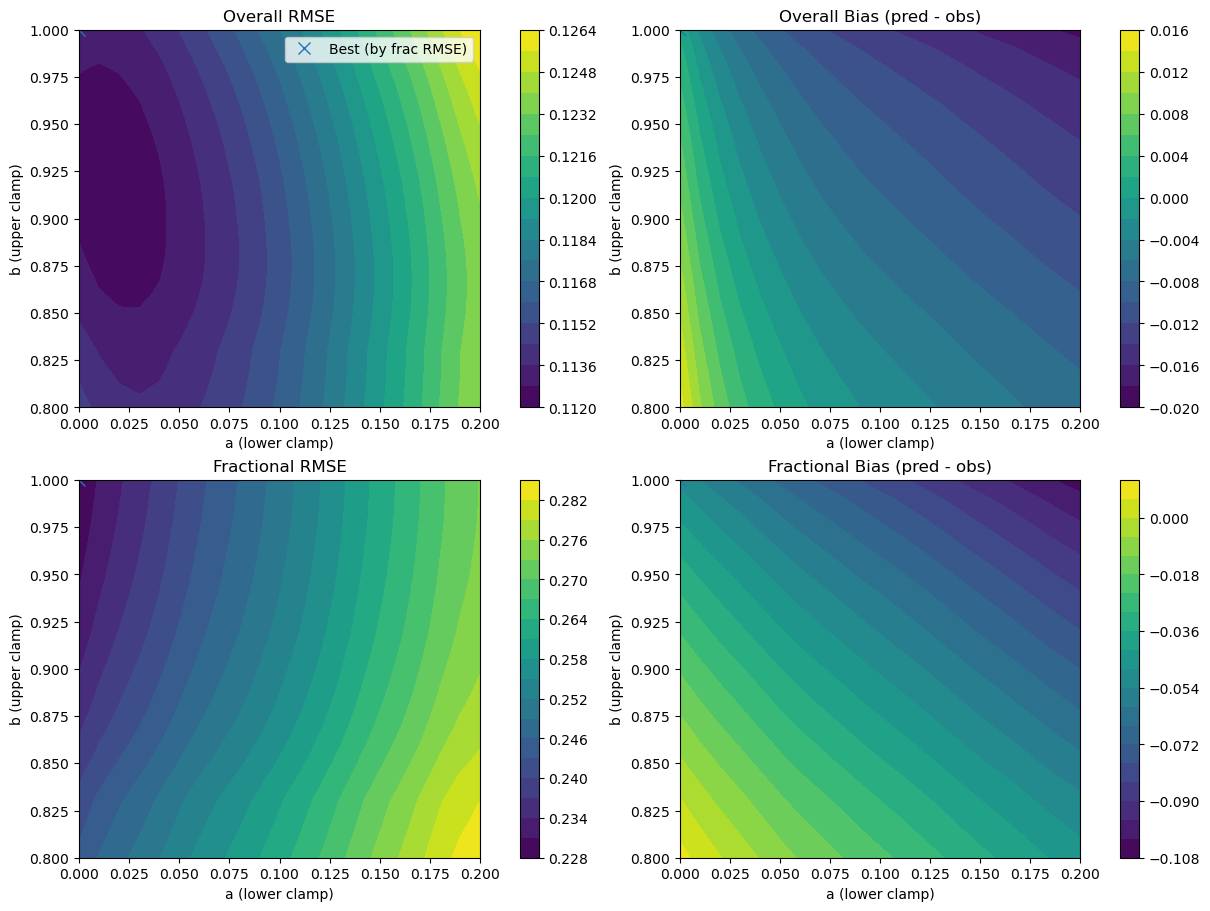

/tmp/ipykernel_951959/3718803589.py:247: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],


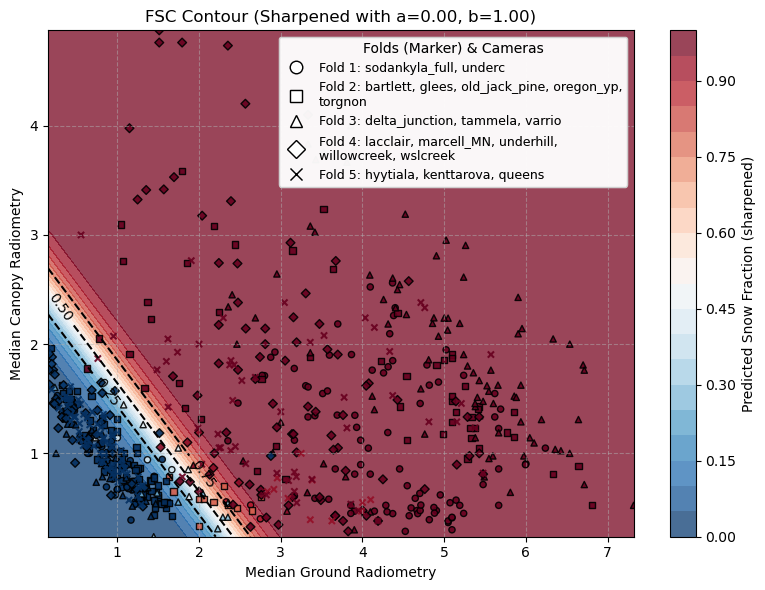

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
from collections import defaultdict
from textwrap import fill

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

def sharpen_piecewise(p, a, b):
    p = np.asarray(p, dtype=float)
    out = (p - a) / (b - a)
    return np.clip(out, 0.0, 1.0)

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date", "camera"]).copy()
combined = df.copy()

X = combined[["Eg_strong", "Ev_strong"]]
y = combined["JointSnowBinary"].astype(float)

# --- Custom Balanced Group Split by Camera ---
n_splits = 5
camera_groups = combined.groupby("camera")
sorted_cameras = sorted(camera_groups.groups.keys(), key=lambda cam: len(camera_groups.get_group(cam)), reverse=True)

folds = [[] for _ in range(n_splits)]
fold_sample_counts = [0] * n_splits
fold_frac_counts = [0] * n_splits
camera_to_fold = {}

# Assign cameras with fractional data first
for cam in sorted_cameras:
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    has_fractional = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).any()
    if has_fractional:
        idx = np.argmin(fold_frac_counts)
        folds[idx].extend(cam_data.index.tolist())
        fold_sample_counts[idx] += n
        fold_frac_counts[idx] += ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        camera_to_fold[cam] = idx

# Assign remaining cameras (no fractional data)
for cam in sorted_cameras:
    if cam in camera_to_fold:
        continue
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    idx = np.argmin(fold_sample_counts)
    folds[idx].extend(cam_data.index.tolist())
    fold_sample_counts[idx] += n
    camera_to_fold[cam] = idx

# --- Fold display prep ---
group_markers = ['o', 's', '^', 'D', 'x'][:n_splits]
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)
row_fold_idx = combined['camera'].map(camera_to_fold)

# --- Print Camera Assignment ---
print("\nCamera-to-Fold Assignment:")
for i in range(n_splits):
    fold_cams = [cam for cam, f in camera_to_fold.items() if f == i]
    total_bin = 0
    total_frac = 0
    print(f"\nFold {i+1}:")
    for cam in fold_cams:
        cam_data = camera_groups.get_group(cam)
        n_total = len(cam_data)
        n_frac = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        n_bin = n_total - n_frac
        total_bin += n_bin
        total_frac += n_frac
        print(f"  - {cam}: {n_total} total ({n_bin} binary, {n_frac} fractional)")
    print(f"  >> Fold {i+1} Total: {total_bin + total_frac} points ({total_bin} binary, {total_frac} fractional)")

# --- Create list of splits (train_idx, val_idx) ---
merged_splits = []
all_indices = set(combined.index)
for i in range(n_splits):
    val_idx = folds[i]
    train_idx = list(all_indices - set(val_idx))
    merged_splits.append((train_idx, val_idx))

# --- Cross-validation: collect UNsharpened OOF predictions ---
rmses, rmses_frac, biases, biases_frac, bin_accuracies = [], [], [], [], []

all_y_val = []
all_p_base = []   # unsharpened OOF predictions
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins_base = []  # bins from base p (for reference)

family = sm.families.Binomial()

for train_idx, val_idx in merged_splits:
    X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
    y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=family)
    result = model.fit()

    p_base = result.predict(X_val_sm)  # UNsharpened

    actual_bins = y_val.apply(fsc_bin)
    pred_bins_base = pd.Series(p_base, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins_base).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, p_base))
    bias = np.mean(p_base - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], p_base[mask_frac]))
        frac_bias = np.mean(p_base[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_p_base.extend(p_base)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins_base.extend(pred_bins_base)

# --- Arrays & masks for sweep ---
all_y_val = np.asarray(all_y_val, dtype=float)
all_p_base = np.asarray(all_p_base, dtype=float)

mask_frac_all = (all_y_val > 0) & (all_y_val < 1)
y_frac = all_y_val[mask_frac_all]
p_frac_base = all_p_base[mask_frac_all]

# --- Grid over a and b ---
a_vals = np.linspace(0.0, 0.2, 21)   # 0.00, 0.01, ..., 0.20
b_vals = np.linspace(0.8, 1.0, 21)   # 0.80, 0.81, ..., 1.00

overall_rmse_grid = np.full((len(a_vals), len(b_vals)), np.nan)
overall_bias_grid = np.full((len(a_vals), len(b_vals)), np.nan)
frac_rmse_grid    = np.full((len(a_vals), len(b_vals)), np.nan)
frac_bias_grid    = np.full((len(a_vals), len(b_vals)), np.nan)

for i, a in enumerate(a_vals):
    for j, b in enumerate(b_vals):
        if b <= a:  # invalid region
            continue
        # Overall
        p_all_sharp = sharpen_piecewise(all_p_base, a, b)
        overall_rmse_grid[i, j] = np.sqrt(mean_squared_error(all_y_val, p_all_sharp))
        overall_bias_grid[i, j] = np.mean(p_all_sharp - all_y_val)
        # Fractional only
        p_frac_sharp = sharpen_piecewise(p_frac_base, a, b)
        frac_rmse_grid[i, j] = np.sqrt(mean_squared_error(y_frac, p_frac_sharp))
        frac_bias_grid[i, j] = np.mean(p_frac_sharp - y_frac)

# --- Best (a,b) by fractional RMSE ---
ij_best = np.unravel_index(np.nanargmin(frac_rmse_grid), frac_rmse_grid.shape)
a_best, b_best = a_vals[ij_best[0]], b_vals[ij_best[1]]
print(f"\nBest (a,b) by fractional RMSE: a={a_best:.3f}, b={b_best:.3f} | "
      f"frac RMSE={frac_rmse_grid[ij_best]:.4f}, frac Bias={frac_bias_grid[ij_best]:.4f}")

# --- Contour Plots: 2x2 (overall + fractional) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

# Helper to plot one contour
def _cont(ax, Z, title, cmap=None):
    # contourf can take x=(N,), y=(M,), Z=(M,N)
    cf = ax.contourf(a_vals, b_vals, Z.T, levels=20, cmap=cmap)
    ax.plot([a_best], [b_best], marker='x', markersize=8, linestyle='None', label='Best (by frac RMSE)')
    ax.set_xlabel("a (lower clamp)")
    ax.set_ylabel("b (upper clamp)")
    ax.set_title(title)
    cbar = fig.colorbar(cf, ax=ax)
    return cf

_ = _cont(axes[0,0], overall_rmse_grid, "Overall RMSE")
_ = _cont(axes[0,1], overall_bias_grid, "Overall Bias (pred - obs)")
_ = _cont(axes[1,0], frac_rmse_grid,    "Fractional RMSE")
_ = _cont(axes[1,1], frac_bias_grid,    "Fractional Bias (pred - obs)")
axes[0,0].legend(loc='best')
plt.show()

# --- Final model on ALL data (unchanged) ---
family = sm.families.Binomial()
X_sm = sm.add_constant(X)
final_model = sm.GLM(y, X_sm, family=family).fit()

# --- Background map using best (a,b) ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel(),
})
grid_df["const"] = 1
grid_df = grid_df[["const", "Eg_strong", "Ev_strong"]]

Z_base = final_model.predict(grid_df).values
Z = sharpen_piecewise(Z_base, a_best, b_best).reshape(Eg_grid.shape)

fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), alpha=0.75, cmap='RdBu_r')
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Predicted Snow Fraction (sharpened)')

lines = ax.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1],
                   colors='k', linestyles='--')
ax.clabel(lines, fmt='%1.2f')

# OOF scatter (colored by observed)
all_point_folds = []
for _, val_idx in merged_splits:
    all_point_folds.extend(row_fold_idx.loc[val_idx].values)
all_point_folds = np.array(all_point_folds)

all_Eg_val_arr = np.asarray(all_Eg_val)
all_Ev_val_arr = np.asarray(all_Ev_val)
all_yval_color_arr = np.asarray(all_yval_color, dtype=float)

for f in range(n_splits):
    m = (all_point_folds == f)
    if not np.any(m):
        continue
    ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
               c=all_yval_color_arr[m], cmap='RdBu_r',
               edgecolor='k', s=20, marker=group_markers[f], alpha=0.9)

# Legend with cameras per fold
fold_handles, fold_labels = [], []
wrap_width = 52
for f in range(n_splits):
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white', markeredgecolor='k', markersize=9)
    cams = sorted(fold_to_cameras.get(f, []))
    label = f"Fold {f+1}: " + (", ".join(cams) if cams else "(no cameras)")
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))
fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds (Marker) & Cameras',
                        loc='upper right', frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(fold_legend)

ax.set_xlabel("Median Ground Radiometry")
ax.set_ylabel("Median Canopy Radiometry")
ax.set_title(f"FSC Contour (Sharpened with a={a_best:.2f}, b={b_best:.2f})")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



Camera-to-Fold Assignment:

Fold 1:
  - sodankyla_full: 101 total (98 binary, 3 fractional)
  - underc: 36 total (31 binary, 5 fractional)
  >> Fold 1 Total: 137 points (129 binary, 8 fractional)

Fold 2:
  - old_jack_pine: 58 total (47 binary, 11 fractional)
  - oregon_yp: 33 total (33 binary, 0 fractional)
  - glees: 28 total (28 binary, 0 fractional)
  - bartlett: 11 total (11 binary, 0 fractional)
  - torgnon: 5 total (5 binary, 0 fractional)
  >> Fold 2 Total: 135 points (124 binary, 11 fractional)

Fold 3:
  - delta_junction: 56 total (38 binary, 18 fractional)
  - varrio: 62 total (62 binary, 0 fractional)
  - tammela: 23 total (23 binary, 0 fractional)
  >> Fold 3 Total: 141 points (123 binary, 18 fractional)

Fold 4:
  - marcell_MN: 52 total (47 binary, 5 fractional)
  - wslcreek: 23 total (17 binary, 6 fractional)
  - willowcreek: 29 total (29 binary, 0 fractional)
  - lacclair: 24 total (24 binary, 0 fractional)
  - underhill: 6 total (6 binary, 0 fractional)
  >> Fold 4 To

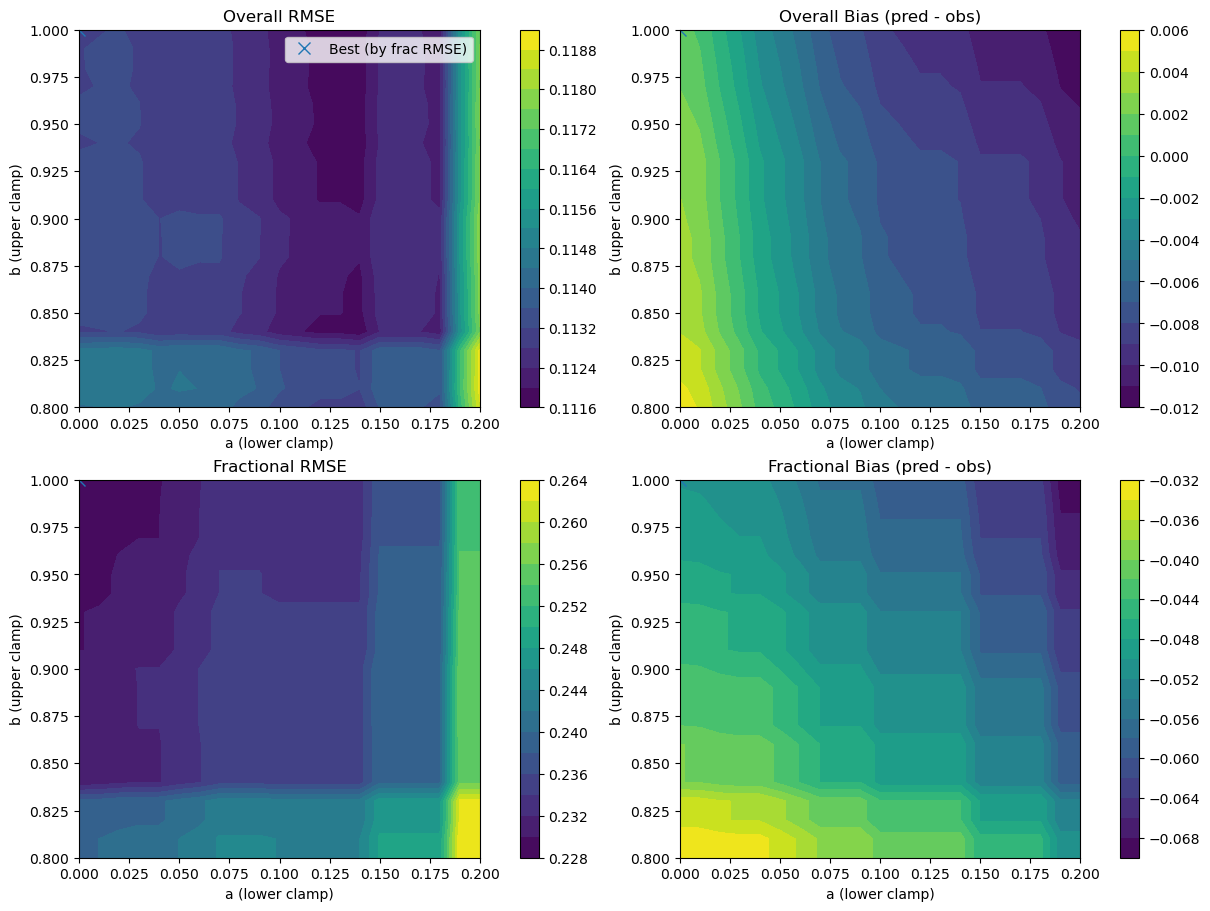

/tmp/ipykernel_951959/3655890784.py:256: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],


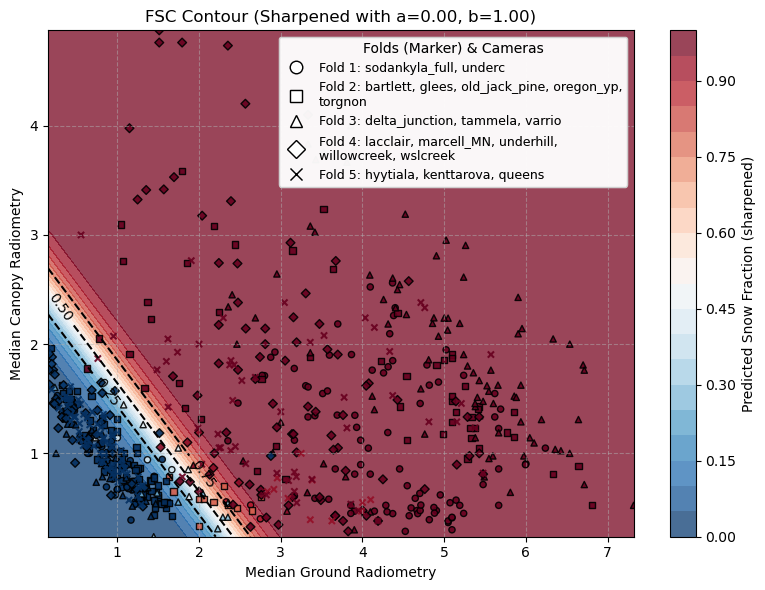

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
from collections import defaultdict
from textwrap import fill

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

def sharpen_piecewise(p, a, b):
    """
    Keep p unchanged if a <= p <= b.
    Set to 0 if p < a, and to 1 if p > b.
    """
    p = np.asarray(p, dtype=float)
    if b <= a:
        raise ValueError("sharpen_piecewise requires b > a")

    out = p.copy()
    out[p < a] = 0.0
    out[p > b] = 1.0
    return np.clip(out, 0.0, 1.0)

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date", "camera"]).copy()
combined = df.copy()

X = combined[["Eg_strong", "Ev_strong"]]
y = combined["JointSnowBinary"].astype(float)

# --- Custom Balanced Group Split by Camera ---
n_splits = 5
camera_groups = combined.groupby("camera")
sorted_cameras = sorted(camera_groups.groups.keys(), key=lambda cam: len(camera_groups.get_group(cam)), reverse=True)

folds = [[] for _ in range(n_splits)]
fold_sample_counts = [0] * n_splits
fold_frac_counts = [0] * n_splits
camera_to_fold = {}

# Assign cameras with fractional data first
for cam in sorted_cameras:
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    has_fractional = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).any()
    if has_fractional:
        idx = np.argmin(fold_frac_counts)
        folds[idx].extend(cam_data.index.tolist())
        fold_sample_counts[idx] += n
        fold_frac_counts[idx] += ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        camera_to_fold[cam] = idx

# Assign remaining cameras (no fractional data)
for cam in sorted_cameras:
    if cam in camera_to_fold:
        continue
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    idx = np.argmin(fold_sample_counts)
    folds[idx].extend(cam_data.index.tolist())
    fold_sample_counts[idx] += n
    camera_to_fold[cam] = idx

# --- Fold display prep ---
group_markers = ['o', 's', '^', 'D', 'x'][:n_splits]
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)
row_fold_idx = combined['camera'].map(camera_to_fold)

# --- Print Camera Assignment ---
print("\nCamera-to-Fold Assignment:")
for i in range(n_splits):
    fold_cams = [cam for cam, f in camera_to_fold.items() if f == i]
    total_bin = 0
    total_frac = 0
    print(f"\nFold {i+1}:")
    for cam in fold_cams:
        cam_data = camera_groups.get_group(cam)
        n_total = len(cam_data)
        n_frac = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        n_bin = n_total - n_frac
        total_bin += n_bin
        total_frac += n_frac
        print(f"  - {cam}: {n_total} total ({n_bin} binary, {n_frac} fractional)")
    print(f"  >> Fold {i+1} Total: {total_bin + total_frac} points ({total_bin} binary, {total_frac} fractional)")

# --- Create list of splits (train_idx, val_idx) ---
merged_splits = []
all_indices = set(combined.index)
for i in range(n_splits):
    val_idx = folds[i]
    train_idx = list(all_indices - set(val_idx))
    merged_splits.append((train_idx, val_idx))

# --- Cross-validation: collect UNsharpened OOF predictions ---
rmses, rmses_frac, biases, biases_frac, bin_accuracies = [], [], [], [], []

all_y_val = []
all_p_base = []   # unsharpened OOF predictions
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins_base = []  # bins from base p (for reference)

family = sm.families.Binomial()

for train_idx, val_idx in merged_splits:
    X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
    y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=family)
    result = model.fit()

    p_base = result.predict(X_val_sm)  # UNsharpened

    actual_bins = y_val.apply(fsc_bin)
    pred_bins_base = pd.Series(p_base, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins_base).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, p_base))
    bias = np.mean(p_base - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], p_base[mask_frac]))
        frac_bias = np.mean(p_base[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_p_base.extend(p_base)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins_base.extend(pred_bins_base)

# --- Arrays & masks for sweep ---
all_y_val = np.asarray(all_y_val, dtype=float)
all_p_base = np.asarray(all_p_base, dtype=float)

mask_frac_all = (all_y_val > 0) & (all_y_val < 1)
y_frac = all_y_val[mask_frac_all]
p_frac_base = all_p_base[mask_frac_all]

# --- Grid over a and b ---
a_vals = np.linspace(0.0, 0.2, 21)   # 0.00, 0.01, ..., 0.20
b_vals = np.linspace(0.8, 1.0, 21)   # 0.80, 0.81, ..., 1.00

overall_rmse_grid = np.full((len(a_vals), len(b_vals)), np.nan)
overall_bias_grid = np.full((len(a_vals), len(b_vals)), np.nan)
frac_rmse_grid    = np.full((len(a_vals), len(b_vals)), np.nan)
frac_bias_grid    = np.full((len(a_vals), len(b_vals)), np.nan)

for i, a in enumerate(a_vals):
    for j, b in enumerate(b_vals):
        if b <= a:  # invalid region
            continue
        # Overall
        p_all_sharp = sharpen_piecewise(all_p_base, a, b)
        overall_rmse_grid[i, j] = np.sqrt(mean_squared_error(all_y_val, p_all_sharp))
        overall_bias_grid[i, j] = np.mean(p_all_sharp - all_y_val)
        # Fractional only
        p_frac_sharp = sharpen_piecewise(p_frac_base, a, b)
        frac_rmse_grid[i, j] = np.sqrt(mean_squared_error(y_frac, p_frac_sharp))
        frac_bias_grid[i, j] = np.mean(p_frac_sharp - y_frac)

# --- Best (a,b) by fractional RMSE ---
ij_best = np.unravel_index(np.nanargmin(frac_rmse_grid), frac_rmse_grid.shape)
a_best, b_best = a_vals[ij_best[0]], b_vals[ij_best[1]]
print(f"\nBest (a,b) by fractional RMSE: a={a_best:.3f}, b={b_best:.3f} | "
      f"frac RMSE={frac_rmse_grid[ij_best]:.4f}, frac Bias={frac_bias_grid[ij_best]:.4f}")

# --- Contour Plots: 2x2 (overall + fractional) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

# Helper to plot one contour
def _cont(ax, Z, title, cmap=None):
    # contourf can take x=(N,), y=(M,), Z=(M,N)
    cf = ax.contourf(a_vals, b_vals, Z.T, levels=20, cmap=cmap)
    ax.plot([a_best], [b_best], marker='x', markersize=8, linestyle='None', label='Best (by frac RMSE)')
    ax.set_xlabel("a (lower clamp)")
    ax.set_ylabel("b (upper clamp)")
    ax.set_title(title)
    cbar = fig.colorbar(cf, ax=ax)
    return cf

_ = _cont(axes[0,0], overall_rmse_grid, "Overall RMSE")
_ = _cont(axes[0,1], overall_bias_grid, "Overall Bias (pred - obs)")
_ = _cont(axes[1,0], frac_rmse_grid,    "Fractional RMSE")
_ = _cont(axes[1,1], frac_bias_grid,    "Fractional Bias (pred - obs)")
axes[0,0].legend(loc='best')
plt.show()

# --- Final model on ALL data (unchanged) ---
family = sm.families.Binomial()
X_sm = sm.add_constant(X)
final_model = sm.GLM(y, X_sm, family=family).fit()

# --- Background map using best (a,b) ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel(),
})
grid_df["const"] = 1
grid_df = grid_df[["const", "Eg_strong", "Ev_strong"]]

Z_base = final_model.predict(grid_df).values
Z = sharpen_piecewise(Z_base, a_best, b_best).reshape(Eg_grid.shape)

fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), alpha=0.75, cmap='RdBu_r')
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Predicted Snow Fraction (sharpened)')

lines = ax.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1],
                   colors='k', linestyles='--')
ax.clabel(lines, fmt='%1.2f')

# OOF scatter (colored by observed)
all_point_folds = []
for _, val_idx in merged_splits:
    all_point_folds.extend(row_fold_idx.loc[val_idx].values)
all_point_folds = np.array(all_point_folds)

all_Eg_val_arr = np.asarray(all_Eg_val)
all_Ev_val_arr = np.asarray(all_Ev_val)
all_yval_color_arr = np.asarray(all_yval_color, dtype=float)

for f in range(n_splits):
    m = (all_point_folds == f)
    if not np.any(m):
        continue
    ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
               c=all_yval_color_arr[m], cmap='RdBu_r',
               edgecolor='k', s=20, marker=group_markers[f], alpha=0.9)

# Legend with cameras per fold
fold_handles, fold_labels = [], []
wrap_width = 52
for f in range(n_splits):
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white', markeredgecolor='k', markersize=9)
    cams = sorted(fold_to_cameras.get(f, []))
    label = f"Fold {f+1}: " + (", ".join(cams) if cams else "(no cameras)")
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))
fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds (Marker) & Cameras',
                        loc='upper right', frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(fold_legend)

ax.set_xlabel("Median Ground Radiometry")
ax.set_ylabel("Median Canopy Radiometry")
ax.set_title(f"FSC Contour (Sharpened with a={a_best:.2f}, b={b_best:.2f})")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
from dataclasses import dataclass
from scipy.optimize import minimize
from scipy.special import expit, logit, betaln

def _add_intercept(X):
    X = np.asarray(X)
    if X.ndim == 1:
        X = X[:, None]
    return np.c_[np.ones(len(X)), X]  # intercept first

@dataclass
class ZOIBModel:
    b0: np.ndarray      # logits for y==0 (k,)
    b1: np.ndarray      # logits for y==1 (k,)
    b_mu: np.ndarray    # beta-mean linear predictor (k,)
    log_phi: float      # log precision (scalar)

    @classmethod
    def fit(cls, X, y, maxiter=200, verbose=False):
        """
        X: (n, p) features (no intercept; we add it)
        y: (n,) fractional in [0,1] (may include exact 0 and 1)
        """
        X = _add_intercept(X)
        y = np.asarray(y)
        n, k = X.shape

        # init: small zeros; phi ~ 10
        theta0 = np.zeros(3*k + 1)
        theta0[-1] = np.log(10.0)

        def unpack(theta):
            b0 = theta[0:k]
            b1 = theta[k:2*k]
            b_mu = theta[2*k:3*k]
            log_phi = theta[-1]
            return b0, b1, b_mu, log_phi

        def nll(theta):
            b0, b1, b_mu, log_phi = unpack(theta)
            eta0 = X @ b0
            eta1 = X @ b1
            # softmax with baseline for beta-part (etaB = 0)
            den = 1.0 + np.exp(eta0) + np.exp(eta1)
            piB = 1.0 / den
            pi0 = np.exp(eta0) / den
            pi1 = np.exp(eta1) / den

            mu = expit(X @ b_mu)              # in (0,1)
            phi = np.exp(log_phi)             # > 0
            a = mu * phi
            b = (1.0 - mu) * phi

            # Build log-likelihood by cases
            eps = 1e-12
            loglik = np.zeros(n)

            idx0 = (y == 0.0)
            idx1 = (y == 1.0)
            idxB = (~idx0) & (~idx1)

            # exact zeros / ones
            loglik[idx0] = np.log(pi0[idx0] + eps)
            loglik[idx1] = np.log(pi1[idx1] + eps)

            # continuous part
            if np.any(idxB):
                yy = np.clip(y[idxB], eps, 1 - eps)
                aB = a[idxB]; bB = b[idxB]; piBB = piB[idxB]
                # log Beta pdf: (a-1)log y + (b-1)log(1-y) - log B(a,b)
                lp_beta = (aB - 1.0) * np.log(yy) + (bB - 1.0) * np.log(1 - yy) - betaln(aB, bB)
                loglik[idxB] = np.log(piBB + eps) + lp_beta

            return -np.sum(loglik)

        res = minimize(nll, theta0, method="L-BFGS-B", options=dict(maxiter=maxiter, disp=verbose))
        if not res.success and verbose:
            print("Warning: optimizer did not converge:", res.message)

        b0, b1, b_mu, log_phi = unpack(res.x)
        return cls(b0=b0, b1=b1, b_mu=b_mu, log_phi=log_phi)

    def _mixture_probs(self, X):
        X = _add_intercept(X)
        eta0 = X @ self.b0
        eta1 = X @ self.b1
        den = 1.0 + np.exp(eta0) + np.exp(eta1)
        piB = 1.0 / den
        pi0 = np.exp(eta0) / den
        pi1 = np.exp(eta1) / den
        return pi0, pi1, piB

    def _beta_params(self, X):
        X = _add_intercept(X)
        mu = expit(X @ self.b_mu)
        phi = np.exp(self.log_phi)
        a = mu * phi
        b = (1.0 - mu) * phi
        return mu, phi, a, b

    def predict_components(self, X):
        """Return dict with pi0, pi1, piB, mu, phi, a, b for analysis."""
        pi0, pi1, piB = self._mixture_probs(X)
        mu, phi, a, b = self._beta_params(X)
        return dict(pi0=pi0, pi1=pi1, piB=piB, mu=mu, phi=phi, a=a, b=b)

    def predict_mean(self, X):
        """
        Expected FSC: E[Y|X] = pi1 + piB * mu
        (zeros contribute 0 by definition).
        """
        pi0, pi1, piB = self._mixture_probs(X)
        mu, _, _, _ = self._beta_params(X)
        return pi1 + piB * mu

    def predict_mode(self, X):
        """
        Mixture mode (heuristic): returns 1 if pi1 is dominant,
        0 if pi0 dominant, else Beta mode ( (a-1)/(a+b-2) ) if a,b>1,
        otherwise mu. Useful for classification maps.
        """
        comps = self.predict_components(X)
        pi0, pi1, piB = comps['pi0'], comps['pi1'], comps['piB']
        a, b = comps['a'], comps['b']
        beta_mode = np.where((a > 1) & (b > 1), (a - 1) / (a + b - 2), comps['mu'])
        # choose the component with highest posterior mass
        choice = np.argmax(np.c_[pi0, piB, pi1], axis=1)
        out = np.where(choice == 0, 0.0, np.where(choice == 2, 1.0, beta_mode))
        return out



Camera-to-Fold Assignment:

Fold 1:
  - sodankyla_full: 101 total (98 binary, 3 fractional)
  - underc: 36 total (31 binary, 5 fractional)
  >> Fold 1 Total: 137 points (129 binary, 8 fractional)

Fold 2:
  - old_jack_pine: 58 total (47 binary, 11 fractional)
  - oregon_yp: 33 total (33 binary, 0 fractional)
  - glees: 28 total (28 binary, 0 fractional)
  - bartlett: 11 total (11 binary, 0 fractional)
  - torgnon: 5 total (5 binary, 0 fractional)
  >> Fold 2 Total: 135 points (124 binary, 11 fractional)

Fold 3:
  - delta_junction: 56 total (38 binary, 18 fractional)
  - varrio: 62 total (62 binary, 0 fractional)
  - tammela: 23 total (23 binary, 0 fractional)
  >> Fold 3 Total: 141 points (123 binary, 18 fractional)

Fold 4:
  - marcell_MN: 52 total (47 binary, 5 fractional)
  - wslcreek: 23 total (17 binary, 6 fractional)
  - willowcreek: 29 total (29 binary, 0 fractional)
  - lacclair: 24 total (24 binary, 0 fractional)
  - underhill: 6 total (6 binary, 0 fractional)
  >> Fold 4 To

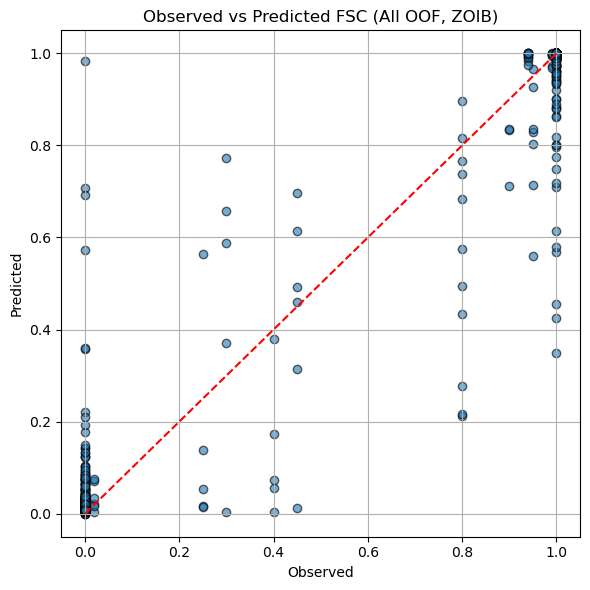

/tmp/ipykernel_951959/2939927588.py:253: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],


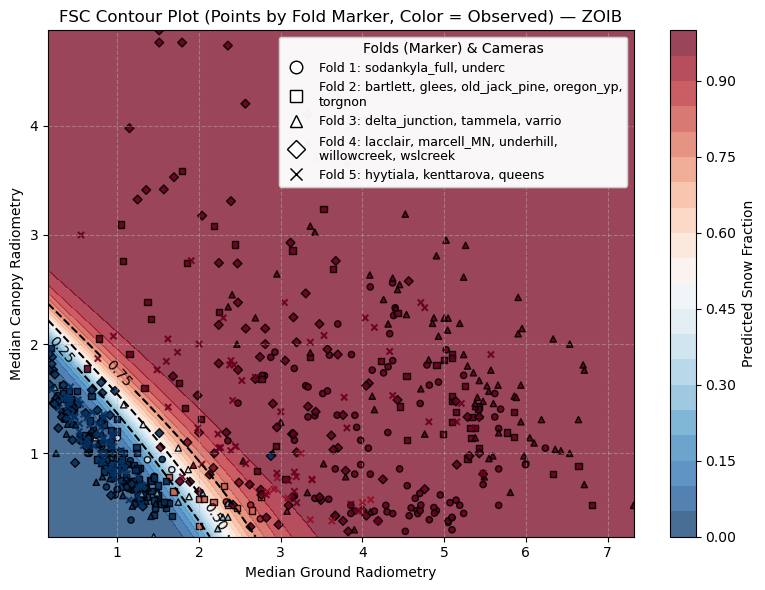

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix

# ---- If needed, import the ZOIBModel from the previous cell/file ----
# from your_module import ZOIBModel

from collections import defaultdict
from textwrap import fill

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date", "camera"]).copy()
combined = df.copy()

X = combined[["Eg_strong", "Ev_strong"]]
y = combined["JointSnowBinary"].astype(float)

# --- Custom Balanced Group Split by Camera ---
n_splits = 5
camera_groups = combined.groupby("camera")

# Sort cameras by total sample count
sorted_cameras = sorted(camera_groups.groups.keys(), key=lambda cam: len(camera_groups.get_group(cam)), reverse=True)

folds = [[] for _ in range(n_splits)]
fold_sample_counts = [0] * n_splits
fold_frac_counts = [0] * n_splits
camera_to_fold = {}

# Assign cameras with fractional data first
for cam in sorted_cameras:
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    has_fractional = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).any()

    if has_fractional:
        idx = np.argmin(fold_frac_counts)
        folds[idx].extend(cam_data.index.tolist())
        fold_sample_counts[idx] += n
        fold_frac_counts[idx] += ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        camera_to_fold[cam] = idx

# Assign remaining cameras (no fractional data)
for cam in sorted_cameras:
    if cam in camera_to_fold:
        continue
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    idx = np.argmin(fold_sample_counts)
    folds[idx].extend(cam_data.index.tolist())
    fold_sample_counts[idx] += n
    camera_to_fold[cam] = idx

##############################
# --- Fold display prep (after camera_to_fold is created) ---
# marker per fold
group_markers = ['o', 's', '^', 'D', 'x'][:n_splits]

# fold -> list of cameras (for legend text)
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)

# per-row fold index for convenience
row_fold_idx = combined['camera'].map(camera_to_fold)
#################################

# --- Print Camera Assignment ---
print("\nCamera-to-Fold Assignment:")
for i in range(n_splits):
    fold_cams = [cam for cam, f in camera_to_fold.items() if f == i]
    total_bin = 0
    total_frac = 0
    print(f"\nFold {i+1}:")
    for cam in fold_cams:
        cam_data = camera_groups.get_group(cam)
        n_total = len(cam_data)
        n_frac = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        n_bin = n_total - n_frac
        total_bin += n_bin
        total_frac += n_frac
        print(f"  - {cam}: {n_total} total ({n_bin} binary, {n_frac} fractional)")
    print(f"  >> Fold {i+1} Total: {total_bin + total_frac} points ({total_bin} binary, {total_frac} fractional)")

# --- Create list of splits (train_idx, val_idx) ---
merged_splits = []
all_indices = set(combined.index)
for i in range(n_splits):
    val_idx = folds[i]
    train_idx = list(all_indices - set(val_idx))
    merged_splits.append((train_idx, val_idx))

# --- Cross-validation to generate OOF predictions for every sample (ZOIB) ---
rmses = []
rmses_frac = []
biases = []
biases_frac = []
bin_accuracies = []

all_y_val = []
all_y_pred = []
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins = []

for train_idx, val_idx in merged_splits:
    X_tr, X_val = X.loc[train_idx].values, X.loc[val_idx].values
    y_tr, y_val = y.loc[train_idx].values, y.loc[val_idx].values

    # ---- Train ZOIB on training fold ----
    model = ZOIBModel.fit(X_tr, y_tr, maxiter=500, verbose=False)

    # ---- Predict expected FSC on validation fold ----
    y_pred = model.predict_mean(X_val)

    actual_bins = pd.Series(y_val, index=val_idx).apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=val_idx).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = float(np.sqrt(mean_squared_error(y_val, y_pred)))
    bias = float(np.mean(y_pred - y_val))
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if np.any(mask_frac):
        frac_rmse = float(np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac])))
        frac_bias = float(np.mean(y_pred[mask_frac] - y_val[mask_frac]))
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val.tolist())
    all_y_pred.extend(y_pred.tolist())
    all_Eg_val.extend(X.loc[val_idx, "Eg_strong"].values.tolist())
    all_Ev_val.extend(X.loc[val_idx, "Ev_strong"].values.tolist())
    all_yval_color.extend(y.loc[val_idx].values.tolist())
    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

# --- Compute OVERALL metrics across ALL OOF predictions ---
all_y_val = np.array(all_y_val, dtype=float)
all_y_pred = np.array(all_y_pred, dtype=float)

overall_rmse = float(np.sqrt(mean_squared_error(all_y_val, all_y_pred)))
overall_bias = float(np.mean(all_y_pred - all_y_val))

# Fractional subset overall
mask_frac_all = (all_y_val > 0) & (all_y_val < 1)
if mask_frac_all.any():
    overall_frac_rmse = float(np.sqrt(mean_squared_error(all_y_val[mask_frac_all], all_y_pred[mask_frac_all])))
    overall_frac_bias = float(np.mean(all_y_pred[mask_frac_all] - all_y_val[mask_frac_all]))
else:
    overall_frac_rmse = np.nan
    overall_frac_bias = np.nan

# Overall 4-bin accuracy across all OOF predictions
all_actual_bins = pd.Series(all_actual_bins)
all_pred_bins = pd.Series(all_pred_bins)
overall_bin_accuracy = float((all_actual_bins == all_pred_bins).mean())

# --- Final model on ALL data (ZOIB) ---
final_model = ZOIBModel.fit(X.values, y.values, maxiter=500, verbose=False)

# --- Summary ---
print("\n=== Cross-Validation (OOF) Metrics Computed OVER ALL Predictions ===")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall Bias: {overall_bias:.4f}")
print(f"Overall Fractional RMSE: {overall_frac_rmse:.4f}")
print(f"Overall Fractional Bias: {overall_frac_bias:.4f}")
print(f"Overall Classification Accuracy (4-bin): {overall_bin_accuracy:.2%}")

# (Optional) Still show per-fold for diagnostics
print("\nPer-fold (diagnostic) means ± std:")
print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Bias: {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE: {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias: {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")

# --- Confusion Matrix (Aggregated across ALL OOF predictions) ---
bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across all OOF predictions):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted FSC (All OOF, ZOIB)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Contour Plot with top-right Fold (marker)+cameras block ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel(),
})

# Predict expected FSC on grid for background (or use predict_mode for crisper 0/1)
Z = final_model.predict_mean(grid_df[["Eg_strong", "Ev_strong"]].values)
Z = Z.reshape(Eg_grid.shape)

fig, ax = plt.subplots(figsize=(8, 6))

# background contours (predicted)
contour = ax.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21),
                      cmap='RdBu_r', alpha=0.75)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Predicted Snow Fraction')

# contour lines
lines = ax.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1],
                   colors='k', linestyles='--')
ax.clabel(lines, fmt='%1.2f')

# Rebuild fold membership for OOF scatter points (aligned with all_* lists)
all_point_folds = []
for _, val_idx in merged_splits:
    all_point_folds.extend(row_fold_idx.loc[val_idx].values)
all_point_folds = np.array(all_point_folds)

all_Eg_val_arr = np.asarray(all_Eg_val)
all_Ev_val_arr = np.asarray(all_Ev_val)
all_yval_color_arr = np.asarray(all_yval_color, dtype=float)

# scatter by fold with unique markers; color = observed (continuous)
for f in range(n_splits):
    m = (all_point_folds == f)
    if not np.any(m):
        continue
    ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
               c=all_yval_color_arr[m], cmap='RdBu_r',
               edgecolor='k', s=20, marker=group_markers[f], alpha=0.9)

# combined top-right block: marker + cameras per fold
fold_handles, fold_labels = [], []
wrap_width = 52  # adjust if your camera names are long
for f in range(n_splits):
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white', markeredgecolor='k', markersize=9)
    cams = sorted(fold_to_cameras.get(f, []))
    label = f"Fold {f+1}: " + (", ".join(cams) if cams else "(no cameras)")
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))

fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds (Marker) & Cameras',
                        loc='upper right', frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(fold_legend)

ax.set_xlabel("Median Ground Radiometry")
ax.set_ylabel("Median Canopy Radiometry")
ax.set_title("FSC Contour Plot (Points by Fold Marker, Color = Observed) — ZOIB")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


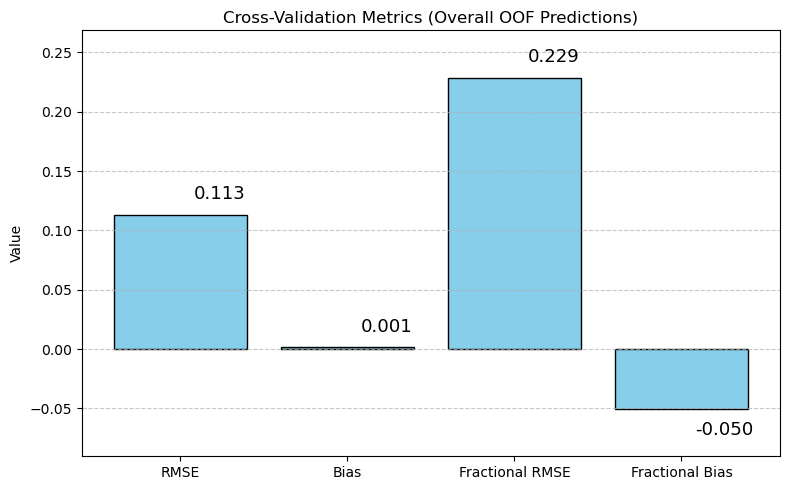

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot (overall metrics, not per-fold means/stdevs)
metrics = [
    "RMSE",
    "Bias",
    "Fractional RMSE",
    "Fractional Bias"
]

means = [
    overall_rmse,
    overall_bias,
    overall_frac_rmse,
    overall_frac_bias
]

# Plotting
plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))
bars = plt.bar(x, means, color='skyblue', edgecolor='black')

# Add labels offset slightly to the right of each bar
for bar, mean in zip(bars, means):
    height = bar.get_height()
    x_offset = bar.get_x() + bar.get_width() * 0.6  # shift label to the right
    y_offset = 0.01 * np.sign(height)
    plt.text(x_offset, height + y_offset, f"{mean:.3f}",
             ha='left', va='bottom' if height >= 0 else 'top', fontsize=13)

plt.xticks(x, metrics)
plt.ylabel("Value")
plt.title("Cross-Validation Metrics (Overall OOF Predictions)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Ensure y-axis has margin so labels don't get cut off ---
ymin = min(0, min(means)) -.04
ymax = max(means) + 0.04 if max(means) > 0 else 1
plt.ylim(ymin, ymax)

plt.tight_layout()
# plt.savefig("poster_reclassified_probit_cv_metrics_overall.svg")
plt.show()



Final model a: 0.4116, b: 1.4152
Final beta: {'const': -1.826891143281726, 'Eg_strong': 1.0748836282506835, 'Ev_strong': 1.0527256984419948}

=== Cross-Validation (OOF) Metrics Computed OVER ALL Predictions ===
Overall RMSE: 0.1144
Overall Bias: -0.0009
Overall Fractional RMSE: 0.2539
Overall Fractional Bias: -0.0301
Overall Classification Accuracy (4-bin): 89.17%

Per-fold (diagnostic) means ± std:
RMSE: 0.1077 ± 0.0385
Bias: -0.0007 ± 0.0198
Fractional RMSE: 0.2256 ± 0.1030
Fractional Bias: -0.0235 ± 0.1209

Confusion Matrix (Aggregated across all OOF predictions):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         239          21           2         1
[0.05,0.5)         8           6           6         1
[0.5,0.95)         0           4           6        16
[0.95,1]           0           4          11       358


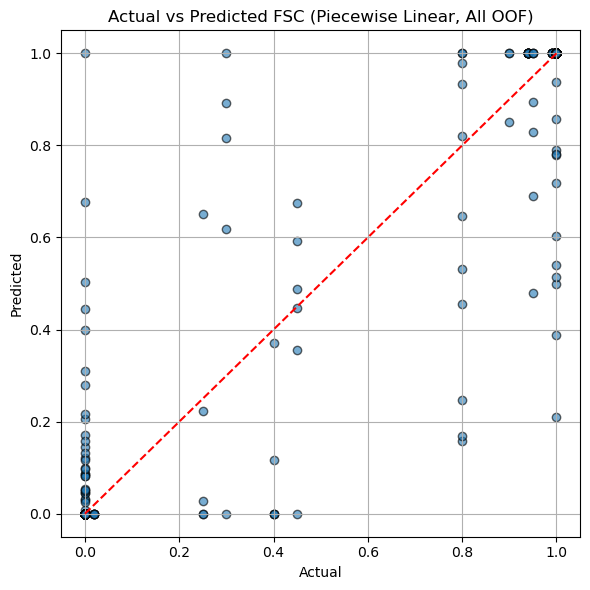

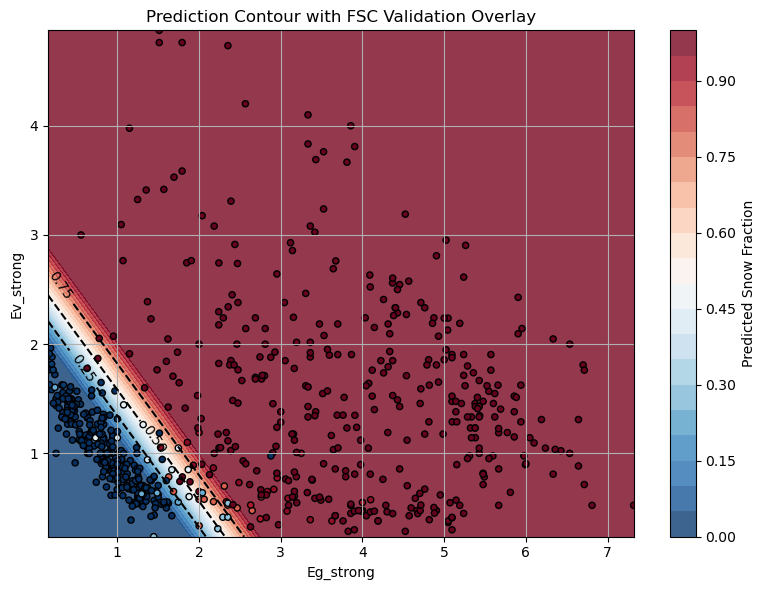

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, confusion_matrix
from scipy.optimize import minimize

# --- Piecewise linear mapping ---
def piecewise_map(z, a, b):
    z = np.asarray(z)
    result = np.zeros_like(z)
    result[z >= b] = 1
    mask = (z > a) & (z < b)
    result[mask] = (z[mask] - a) / (b - a)
    return result

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "pv", "pg", "pvpg", "JointSnowBinary", "date"]).copy()
combined = df.copy()

X_raw = combined[["Eg_strong", "Ev_strong"]].copy()
X = X_raw.copy()
X.insert(0, "const", 1)
y = combined["JointSnowBinary"].astype(float)
groups = combined["date"]
X_cols = X.columns

# --- Stratified GroupKFold on binary vs fractional data ---
binary_mask = (y == 0) | (y == 1)
frac_mask = ~binary_mask
gkf = GroupKFold(n_splits=5)

binary_splits = list(gkf.split(X[binary_mask], y[binary_mask], groups=groups[binary_mask]))
frac_splits = list(gkf.split(X[frac_mask], y[frac_mask], groups=groups[frac_mask]))

merged_splits = []
for (b_tr, b_val), (f_tr, f_val) in zip(binary_splits, frac_splits):
    train_idx = X[binary_mask].index[b_tr].tolist() + X[frac_mask].index[f_tr].tolist()
    val_idx = X[binary_mask].index[b_val].tolist() + X[frac_mask].index[f_val].tolist()
    merged_splits.append((train_idx, val_idx))

# --- Cross-validation ---
rmses, rmses_frac, biases, biases_frac, bin_accuracies = [], [], [], [], []
all_y_val, all_y_pred = [], []
all_Eg_val, all_Ev_val, all_yval_color = [], [], []
all_actual_bins, all_pred_bins = [], []

for train_idx, val_idx in merged_splits:
    X_tr = X.loc[train_idx].values
    y_tr = y.loc[train_idx].values
    X_val = X.loc[val_idx].values
    y_val = y.loc[val_idx]

    def objective(params):
        a, b = params[-2], params[-1]
        if b <= a:
            return np.inf
        beta = params[:-2]
        z = X_tr @ beta
        y_pred = piecewise_map(z, a, b)
        return np.sqrt(mean_squared_error(y_tr, y_pred))

    init_params = np.zeros(X_tr.shape[1] + 2)
    init_params[-2] = -1
    init_params[-1] = 1
    res = minimize(objective, init_params, method='L-BFGS-B')
    params = res.x
    beta, a, b = params[:-2], params[-2], params[-1]

    z_val = X_val @ beta
    y_pred = piecewise_map(z_val, a, b)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val.tolist())
    all_y_pred.extend(y_pred.tolist())
    all_Eg_val.extend(X_raw.loc[val_idx, "Eg_strong"].tolist())
    all_Ev_val.extend(X_raw.loc[val_idx, "Ev_strong"].tolist())
    all_yval_color.extend(y_val.tolist())
    all_actual_bins.extend(actual_bins.tolist())
    all_pred_bins.extend(pred_bins.tolist())

# === NEW: Compute OVERALL metrics across ALL OOF predictions ===
all_y_val = np.array(all_y_val, dtype=float)
all_y_pred = np.array(all_y_pred, dtype=float)

overall_rmse = float(np.sqrt(mean_squared_error(all_y_val, all_y_pred)))
overall_bias = float(np.mean(all_y_pred - all_y_val))

mask_frac_all = (all_y_val > 0) & (all_y_val < 1)
if mask_frac_all.any():
    overall_frac_rmse = float(np.sqrt(mean_squared_error(all_y_val[mask_frac_all], all_y_pred[mask_frac_all])))
    overall_frac_bias = float(np.mean(all_y_pred[mask_frac_all] - all_y_val[mask_frac_all]))
else:
    overall_frac_rmse = np.nan
    overall_frac_bias = np.nan

all_actual_bins = pd.Series(all_actual_bins)
all_pred_bins = pd.Series(all_pred_bins)
overall_bin_accuracy = float((all_actual_bins == all_pred_bins).mean())

# --- Final model on all data ---
X_all = X.values
y_all = y.values

def final_objective(params):
    a, b = params[-2], params[-1]
    if b <= a:
        return np.inf
    beta = params[:-2]
    z = X_all @ beta
    y_pred = piecewise_map(z, a, b)
    return np.sqrt(mean_squared_error(y_all, y_pred))

init_params = np.zeros(X_all.shape[1] + 2)
init_params[-2] = -1
init_params[-1] = 1
res_final = minimize(final_objective, init_params, method='L-BFGS-B')
params_final = res_final.x
beta_final, a_final, b_final = params_final[:-2], params_final[-2], params_final[-1]
print(f"\nFinal model a: {a_final:.4f}, b: {b_final:.4f}")
print("Final beta:", dict(zip(X_cols, beta_final)))

# --- Summary (same style as before) ---
print("\n=== Cross-Validation (OOF) Metrics Computed OVER ALL Predictions ===")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall Bias: {overall_bias:.4f}")
print(f"Overall Fractional RMSE: {overall_frac_rmse:.4f}")
print(f"Overall Fractional Bias: {overall_frac_bias:.4f}")
print(f"Overall Classification Accuracy (4-bin): {overall_bin_accuracy:.2%}")

# (Optional) Still show per-fold diagnostics
print("\nPer-fold (diagnostic) means ± std:")
print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Bias: {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE: {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias: {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")

# --- Confusion Matrix (Aggregated across ALL OOF predictions) ---
bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across all OOF predictions):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted FSC (Piecewise Linear, All OOF)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Prediction Grid (background) ---
eg_vals = np.linspace(X_raw["Eg_strong"].min(), X_raw["Eg_strong"].max(), 300)
ev_vals = np.linspace(X_raw["Ev_strong"].min(), X_raw["Ev_strong"].max(), 300)
EG, EV = np.meshgrid(eg_vals, ev_vals)

# pv_fixed = X_raw["pv"].median()
# pg_fixed = X_raw["pg"].median()
# pvpg_fixed = X_raw["pvpg"].median()

grid_df = pd.DataFrame({
    "const": 1,
    "Eg_strong": EG.ravel(),
    "Ev_strong": EV.ravel()
    # "pv": pv_fixed,
    # "pg": pg_fixed,
    # "pvpg": pvpg_fixed
})
z_grid = grid_df.values @ beta_final
Z = piecewise_map(z_grid, a_final, b_final).reshape(EG.shape)

# --- Contour Plot ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(EG, EV, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.8)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(EG, EV, Z, levels=[0.25, 0.5, 0.75], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

plt.scatter(all_Eg_val, all_Ev_val, c=all_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Prediction Contour with FSC Validation Overlay")
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
# import matplotlib.pyplot as plt

# # Data to plot
# metrics = [
#     "RMSE",
#     "Bias",
#     "Fractional RMSE",
#     "Fractional Bias"
# ]

# means = [
#     np.mean(rmses),
#     np.mean(biases),
#     np.mean(rmses_frac),
#     np.mean(biases_frac)
# ]

# stds = [
#     np.std(rmses),
#     np.std(biases),
#     np.std(rmses_frac),
#     np.std(biases_frac)
# ]

# # Plotting
# plt.figure(figsize=(8, 5))
# x = np.arange(len(metrics))
# plt.bar(x, means, yerr=stds, capsize=6, color='skyblue', edgecolor='black')
# plt.xticks(x, metrics)
# plt.ylabel("Value")
# plt.title("Cross-Validation RMSE and Bias (±1 SD)")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# # plt.savefig("poster_fraction_probit_cv_metrics_more.svg")
# plt.show()


### Plotting fractional data

In [60]:
# from scripts.parallel_blocks_WIP import *
    
# # misclassified.columns
# for idx, row in frac_data.sort_values('FSC').iterrows():
#     plt.figure()
#     plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
    
#     test_plot = df[(df['camera'] == row['camera']) &
#                    (df['date'] == row['date']) &
#                    (df['lon'] == row['lon']) &
#                    (df['lat'] == row['lat'])].copy()

#     params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

#     # print(test)

#     # Get sorted unique beams (hue order used by seaborn)
#     beam_order = sorted(test['beam'].unique())

#     # Create mapping from beam label to tab10 color
#     tab10 = cm.get_cmap('tab10')
#     color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

#     # Plot with fixed hue order and palette
#     sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
#                     hue_order=beam_order, palette=color_map)

#     # Plot ODR lines in matching colors
#     for b, beam in zip(params[1:], beam_order):
#         plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

#     plt.xlim(0, 8)
#     plt.ylim(0, 8)
#     plt.legend()
#     plt.show()

#     # break

# combining plots from landsat and icesat-2

In [133]:
from scripts.imports import *
from rasterio.enums import Resampling
from shapely.geometry import Polygon, Point

def find_masks(folder, cam):
    for filename in os.listdir(folder):
        if cam in filename and 'LandCover' in filename:
            corine_filepath = os.path.join(folder, filename)
        elif cam in filename and 'ALOS' in filename:
            elevation_filepath = os.path.join(folder, filename)
    return corine_filepath, elevation_filepath

def load_and_reproject_to_landsat(source_path, match_array, band_name, method=Resampling.nearest):
    src = rioxarray.open_rasterio(source_path, masked=True).squeeze()
    src.name = band_name
    return src.rio.reproject_match(match_array, resampling=method)

def combine_tifs(landsat_filepath, corine_filepath, elevation_filepath):
    landsat = rioxarray.open_rasterio(landsat_filepath, masked=True).squeeze()
    landsat.name = "landsat"
    corine = load_and_reproject_to_landsat(corine_filepath, landsat, "corine_landcover")
    elevation = load_and_reproject_to_landsat(elevation_filepath, landsat, "elevation")
    return xr.merge([landsat, corine, elevation])

def apply_valid_mask(ds, e=80):
    elevation = ds['elevation']
    corine = ds['corine_landcover']
    yc, xc = elevation.sizes['y'] // 2, elevation.sizes['x'] // 2
    centre_elev = elevation.isel(y=yc, x=xc).item()
    elev_mask = np.abs(elevation - centre_elev) <= e
    corine_mask = (corine >= 111) & (corine <= 126)
    valid_mask = elev_mask & corine_mask
    ds['valid_mask'] = valid_mask
    return ds

def compute_ndvi(red, nir):
    return (nir - red) / (nir + red)

def compute_ndsi(green, swir):
    return (green - swir) / (green + swir)

def compute_dozier(ds, ndsi, nir):
    corine = ds['corine_landcover']
    condition1 = (ndsi > 0.1) & (ndsi < 0.4) # & (corine >= 111) & (corine <= 126)
    condition2 = (ndsi >= 0.4) & (nir > 0.11) # ~((corine >= 111) & (corine <= 126))
    dozier = xr.where(condition1 | condition2, 1, 0)
    return dozier.where(~np.isnan(ndsi))

def compute_klein(ndsi, ndvi, green, nir):
    region_coords = [
        (0.4, 1), (0.33, 0.91), (0.26, 0.75),
        (0.2, 0.6), (0.1, 0.25), (0.4, 0.1),
    ]
    polygon = Polygon(region_coords)
    klein = xr.zeros_like(ndsi)
    klein = xr.where(ndsi >= 0.4, 1, klein)
    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    mask = np.zeros(ndsi.shape, dtype=bool)
    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            if not np.isnan(ndsi_vals[i, j]) and not np.isnan(ndvi_vals[i, j]):
                if polygon.contains(Point(ndsi_vals[i, j], ndvi_vals[i, j])):
                    mask[i, j] = True
    klein = xr.where(xr.DataArray(mask, dims=ndsi.dims, coords=ndsi.coords), 1, klein)
    klein = xr.where((green <= 0.1) | (nir <= 0.11), 0, klein)
    return klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

def compute_salomonson(ndsi):
    fsc = 0.06 + 1.21 * ndsi
    return fsc.clip(0, 1).where(~np.isnan(ndsi))

def normalize(img):
    img = img.transpose("y", "x", "band")
    p2 = img.quantile(0.02, dim=("x", "y"))
    p98 = img.quantile(0.98, dim=("x", "y"))
    return ((img - p2) / (p98 - p2)).clip(0, 1)

def plot_rgb(ds, landsat, cam, filtered=True):
    rgb_bands = [2, 1, 0] if landsat == 'Landsat7' else [3, 2, 1]
    rgb = ds['landsat'].isel(band=rgb_bands)

    if filtered and 'valid_mask' in ds:
        # Apply valid mask across all bands
        mask = ds['valid_mask']
        rgb = rgb.where(mask)

    rgb = normalize(rgb)

    plt.figure(figsize=(8, 8))
    title = f"RGB Composite for {cam}" + (" (Filtered)" if filtered else " (Raw)")
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

import os
import re

def process_scene(i, apply_filter=True, plot_rgb_image=True, e=80):
    cams = ['bartlett', 'delta_junction', 'glees', 'hyytiala', 'kenttarova', 'lacclair', 'marcell', 'old_jack_pine',
            'oregon', 'queens', 'sodankyla', 'torgnon', 'underc', 'underhill', 'varrio', 'willowcreek', 'wslcreek']

    landsat_folder = '../scratch/data/landsat/'
    landsat_filepaths = sorted([
        os.path.join(landsat_folder, f) for f in os.listdir(landsat_folder)
        if os.path.isfile(os.path.join(landsat_folder, f))
    ])

    filepath = landsat_filepaths[i]
    cam = [c for c in cams if c in filepath][0]
    landsat = [l for l in ['Landsat7', 'Landsat8'] if l in filepath][0]

    # Extract FSC number from filename (e.g. 'bartlett80_')
    match = re.search(rf"{cam}(\d+)_", os.path.basename(filepath))
    fsc_value = int(match.group(1)) if match else None

    landsat_masking_folder = '../scratch/data/landsat_masking/'
    corine_fp, elev_fp = find_masks(landsat_masking_folder, cam)
    print(f"Processing i={i}: {filepath}")
    
    ds = combine_tifs(filepath, corine_fp, elev_fp)
    ds = apply_valid_mask(ds, e)

    bgrns = [1, 2, 3, 4, 5] if landsat == 'Landsat7' else [2, 3, 4, 5, 6]
    red, green, blue, nir, swir = [ds['landsat'].isel(band=b - 1) for b in bgrns]

    ndsi = compute_ndsi(green, swir)
    ndvi = compute_ndvi(red, nir)

    dozier = compute_dozier(ds, ndsi, nir)
    klein = compute_klein(ndsi, ndvi, green, nir)
    fsc = compute_salomonson(ndsi)
    if apply_filter:
        dozier = dozier.where(ds['valid_mask'])
        klein = klein.where(ds['valid_mask'])
        fsc = fsc.where(ds['valid_mask'])
    
    ds['Dozier'] = dozier.assign_attrs(name="Dozier")
    ds['Klein'] = klein.assign_attrs(name="Klein")
    ds['Salomonson'] = fsc.assign_attrs(name="Salomonson")

    if plot_rgb_image:
        plot_rgb(ds, landsat, cam, filtered=False)

    return ds, fsc_value, cam

def subcell_stats(ds, var='Salomonson', apply_filter=True, extent=4):
    """
    Compute mean value and valid_mask fraction in fixed 8x8 grid over dataset in meters.

    Args:
        ds (xr.Dataset): Dataset with 2D variable `var` and 'valid_mask'
        var (str): Variable to average (default: 'Salomonson')
        apply_filter (bool): If True, use 'valid_mask' to filter pixels before averaging

    Returns:
        pd.DataFrame with columns: ['cell_y', 'cell_x', 'mean', 'filtered_fraction']
    """
    data = ds[var]
    mask = ds['valid_mask']

    # Get coordinates
    y_vals = data['y'].values
    x_vals = data['x'].values
    yy, xx = np.meshgrid(y_vals, x_vals, indexing="ij")

    flat_y = yy.ravel()
    flat_x = xx.ravel()
    flat_data = data.values.ravel()
    flat_mask = mask.values.ravel()

    # Get bounding box and define 8 even bins in each direction
    y_min, y_max = y_vals.min(), y_vals.max()
    x_min, x_max = x_vals.min(), x_vals.max()

    y_edges = np.linspace(y_min, y_max, 9)  # 8 bins = 9 edges
    x_edges = np.linspace(x_min, x_max, 9)

    # Digitize assigns bin 1–8; subtract 1 → 0–7 for indexing
    cell_y = np.digitize(flat_y, y_edges) - 1
    cell_x = np.digitize(flat_x, x_edges) - 1

    # Keep only points within bin ranges
    valid = (cell_y >= 4 - extent) & (cell_y < 4 + extent) & (cell_x >= 4 - extent) & (cell_x < 4 + extent)

    df = pd.DataFrame({
        'cell_y': cell_y[valid],
        'cell_x': cell_x[valid],
        'data': flat_data[valid],
        'mask': flat_mask[valid]
    })

    # if apply_filter:
    #     df = df[df['mask'] == True]

    grouped = df.groupby(['cell_y', 'cell_x'], as_index=False).agg(
        mean=('data', 'mean'),
        filtered_fraction=('mask', lambda v: np.count_nonzero(v == True) / np.count_nonzero(~np.isnan(v)))
        if apply_filter else
        ('mask', lambda v: 1.0)  # If not filtering, assume full coverage
    )

    return grouped

N = len([f for f in os.listdir('../scratch/data/landsat/') if os.path.isfile(os.path.join('../scratch/data/landsat/', f))])
print(N)

merged_results = []

for i in range(N):  # or range(1) for testing
    ds, fsc, cam = process_scene(i=i, apply_filter=True, plot_rgb_image=False, e=80)
    
    print(fsc)
    fsc_norm = fsc / 100

    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    
    # ds.Dozier.plot(ax=axes[0])
    # axes[0].set_title("Dozier")
    
    # ds.Klein.plot(ax=axes[1])
    # axes[1].set_title("Klein")
    
    # ds.Salomonson.plot(ax=axes[2])
    # axes[2].set_title("Salomonson")
    
    # plt.tight_layout()
    # plt.show()

    # Get results for all three metrics
    dozier = subcell_stats(ds, var='Dozier', apply_filter=True, extent=4)
    klein = subcell_stats(ds, var='Klein', apply_filter=True, extent=4)
    salo  = subcell_stats(ds, var='Salomonson', apply_filter=True, extent=4)

    # Filter by valid fraction
    dozier = dozier.where(dozier['filtered_fraction'] >= 0.2).dropna()
    klein  = klein.where(klein['filtered_fraction'] >= 0.2).dropna()
    salo   = salo.where(salo['filtered_fraction'] >= 0.2).dropna()

    # Merge on cell_x and cell_y
    merged = dozier[['cell_y', 'cell_x', 'filtered_fraction', 'mean']].rename(columns={'mean': 'Dozier'}) \
        .merge(klein[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Klein'}), on=['cell_y', 'cell_x']) \
        .merge(salo[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Salomonson'}), on=['cell_y', 'cell_x'])

    # Add fsc column
    merged['fsc'] = fsc_norm
    merged['cam'] = cam
    merged_results.append(merged)

# Final DataFrame
final_df = pd.concat(merged_results, ignore_index=True)

print(final_df)

58
Processing i=0: ../scratch/data/landsat/Landsat7_bartlett90_clouds4_LE07_L2SP_013029_20220323_20220419_02_T1.tif
90
Processing i=1: ../scratch/data/landsat/Landsat7_hyytiala95_clouds6_LE07_L2SP_189017_20190417_20200827_02_T1.tif
95
Processing i=2: ../scratch/data/landsat/Landsat7_kenttarova98_clouds0_LE07_L2SP_192012_20200526_20200820_02_T1.tif
98
Processing i=3: ../scratch/data/landsat/Landsat7_lacclair90_clouds0_LE07_L2SP_013027_20190502_20200825_02_T1.tif
90
Processing i=4: ../scratch/data/landsat/Landsat7_marcell100_clouds12_LE07_L2SP_028027_20200326_20200822_02_T1.tif
100
Processing i=5: ../scratch/data/landsat/Landsat7_marcell60_clouds0_LE07_L2SP_027027_20210306_20210401_02_T1.tif
60
Processing i=6: ../scratch/data/landsat/Landsat7_marcell70_clouds0_LE07_L2SP_027027_20200404_20200822_02_T1.tif
70
Processing i=7: ../scratch/data/landsat/Landsat7_marcell80_clouds0_LE07_L2SP_028027_20210313_20210410_02_T1.tif
80
Processing i=8: ../scratch/data/landsat/Landsat7_old_jack_pine44_clo

/tmp/ipykernel_3582932/2561738338.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = melted.groupby("method", as_index=False).apply(compute_rmse_bias).reset_index(drop=True)


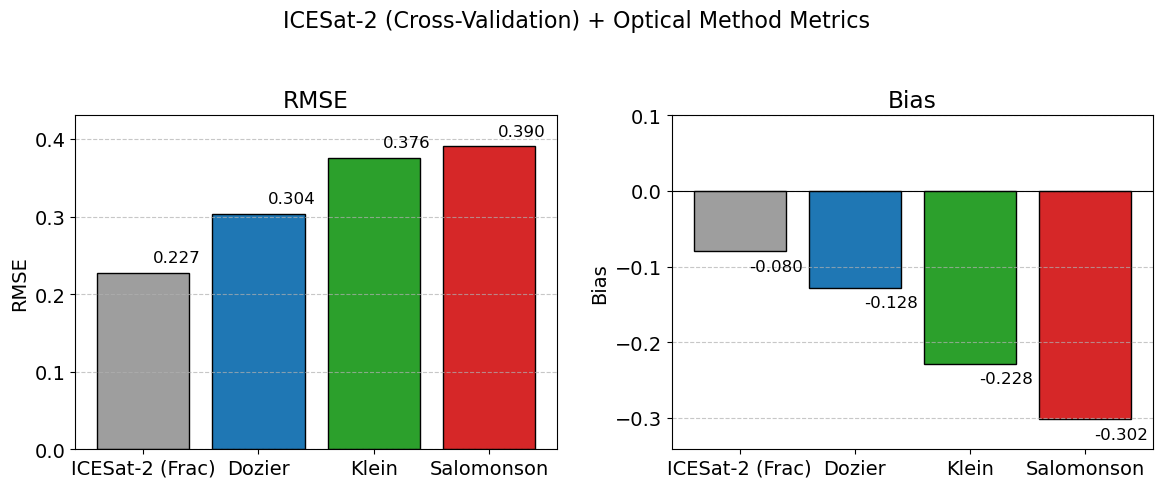

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Expects these to already exist:
# - final_df with columns ['fsc','filtered_fraction','cam','Dozier','Klein','Salomonson']
# - overall_rmse, overall_bias, overall_frac_rmse, overall_frac_bias (from your OOF script)
# -------------------------------------------------------------------

# Compute per-method RMSE/Bias from final_df
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein", "Salomonson"],
    var_name="method",
    value_name="predicted"
)

def compute_rmse_bias(g):
    rmse = np.sqrt(np.mean((g["predicted"] - g["fsc"])**2))
    bias = np.mean(g["predicted"] - g["fsc"])
    return pd.Series({"RMSE": rmse, "Bias": bias})

metrics_df = melted.groupby("method", as_index=False).apply(compute_rmse_bias).reset_index(drop=True)

methods = ["Dozier", "Klein", "Salomonson"]
rmse_vals = [metrics_df.loc[metrics_df["method"] == m, "RMSE"].values[0] for m in methods]
bias_vals = [metrics_df.loc[metrics_df["method"] == m, "Bias"].values[0] for m in methods]

# Add overall metrics (from OOF predictions)
labels = ['ICESat-2 (Frac)'] + methods #["Overall", "Overall (Frac)"]
rmse_all = [overall_frac_rmse] + rmse_vals #[overall_rmse, overall_frac_rmse]
bias_all = [overall_frac_bias] + bias_vals #[overall_bias, overall_frac_bias]

# Colors
colors = {
    "ICESat-2 (Frac)": "#9e9e9e",
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    "Salomonson": "#d62728",
    #"Overall": "#7f7f7f",
}

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax_rmse, ax_bias = axes

# RMSE panel
x_rmse = np.arange(len(labels))
bars_rmse = ax_rmse.bar(x_rmse, rmse_all,
                        color=[colors[l] for l in labels], edgecolor='black')
ax_rmse.set_xticks(x_rmse)
ax_rmse.set_xticklabels(labels, rotation=0)
ax_rmse.set_ylabel("RMSE")
ax_rmse.set_title("RMSE")
ax_rmse.grid(axis='y', linestyle='--', alpha=0.7)

# Labels on bars
for bar, val in zip(bars_rmse, rmse_all):
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 0.01 * np.sign(val)
    ax_rmse.text(x_offset, val + y_offset, f"{val:.3f}",
                 ha='left', va='bottom' if val >= 0 else 'top', fontsize=12)

# y-limits with padding (like your tweak)
ymin_r = min(0, min(rmse_all) - 0.04 )
ymax_r = (max(rmse_all) + 0.04) if max(rmse_all) > 0 else 1
ax_rmse.set_ylim(ymin_r, ymax_r)

# Bias panel
x_bias = np.arange(len(labels))
bars_bias = ax_bias.bar(x_bias, bias_all,
                        color=[colors[l] for l in labels], edgecolor='black')
ax_bias.set_xticks(x_bias)
ax_bias.set_xticklabels(labels, rotation=0)
ax_bias.set_ylabel("Bias")
ax_bias.set_title("Bias")
ax_bias.axhline(0, color='black', lw=0.8)
ax_bias.grid(axis='y', linestyle='--', alpha=0.7)

for bar, val in zip(bars_bias, bias_all):
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 0.01 * np.sign(val)
    ax_bias.text(x_offset, val + y_offset, f"{val:.3f}",
                 ha='left', va='bottom' if val >= 0 else 'top', fontsize=12)

ymin_b = min(0, min(bias_all) - 0.04 )
ymax_b = max(0, max(bias_all)+ 0.04) if max(bias_all) > 0 else 0.1
ax_bias.set_ylim(ymin_b, ymax_b)

plt.suptitle("ICESat-2 (Cross-Validation) + Optical Method Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("combined_methods_overall_metrics.svg")
plt.show()
